# tests de las funciones de 'escanear examenes' de pyexams

In [1]:
import PyPDF2 as pypdf
import json
import os
from pdf2image import convert_from_path
import numpy as np
import cv2
from functools import reduce
import sys

In [2]:
import matplotlib.pyplot as plt
debug = True

In [3]:
def detect_filled(boxes, exam, variant):
    data = {'exam': exam,
            'variant': variant,
            'num_boxes': boxes.__len__(),
            'exercises': []}
    count_ex = -1
    count_box = -1
    count_page = 1
    last_y = sys.float_info.max
    for box in boxes:
        exercise = box.split(sep=':')[2]
        if not data['exercises'] or (data['exercises'][count_ex]['exercise'] != exercise):
            count_ex = count_ex + 1
            count_box = -1
            data['exercises'].append(
                {
                    'exercise': exercise,
                    'checkboxes': []
                }
            )
            data['exercises'][count_ex]['student_marked'] = []
        x1, y1, x2, y2 = [float(i) for i in boxes[box]['/Rect']]
        if y1 > last_y:
            count_page = count_page + 1
        last_y = y1
        count_box = count_box + 1
        data['exercises'][count_ex]['checkboxes'].append(
            {
                'checkbox': str(count_ex) + ',' + str(count_box),
                'cords': [x1, y1, round(x2 - x1, 3), round(y2 - y1, 3)],
                'page': count_page
            })
        if boxes[box]['/V'] == '/Yes':
            data['exercises'][count_ex]['student_marked'].append(str(count_ex) + ',' + str(count_box))
    return data

In [4]:
def find_qrs(file, dpi):
    # TODO: improve qr detection
    pages = convert_from_path(file, dpi=dpi, thread_count=1, fmt='png')
    img_file = 'img_temp.png'
    qrs = []
    for page in pages:
        page.save(img_file)
        img = cv2.imread(img_file)
        qr_detect = cv2.QRCodeDetector()
        # process the image
        _, img_th = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
        # keep only black pixels
        hsv_img = cv2.cvtColor(img_th, cv2.COLOR_BGR2HSV)
        lower_values = np.array([0,0,0])
        upper_values = np.array([180,255,30])
        black_mask = cv2.inRange(hsv_img, lower_values, upper_values)
        # blur, sharpen and recognize the qr
        blur = cv2.GaussianBlur(black_mask, (3, 3), 0)
        sharpen = cv2.filter2D(blur, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
        value, coordinates, qr = qr_detect.detectAndDecode(~sharpen)
        # if it doesn't find the qr, loop blur and sharpen until it does, up to 5 times
        count = 0
        while qr is None:
            if count == 5:
                print('Error: QR not found')
                break
            blur = cv2.GaussianBlur(sharpen, (3, 3), 0)
            sharpen = cv2.filter2D(blur, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
            value, coordinates, qr = qr_detect.detectAndDecode(~sharpen)
            count = count + 1
        exam, variant, page = '', '', ''
        if value:
            exam, variant, page = value.split(sep=',')
        qrs.append({'exam': exam, 'variant': variant, 'page': page, 'coordinates': coordinates})
    if os.path.exists(img_file):
        os.remove(img_file)
    return qrs

In [5]:
def analyse(file, sol_json="", dpi=300):
    # TODO: check if all qrs are from the same exam and variant
    # TODO: deal with the JSON file parameter
    # check if pyPDF2 can detect the boxes
    boxes = pypdf.PdfFileReader(file).getFields()
    # find qrs in the pdf
    qr_codes = find_qrs(file, dpi)
    exam, variant = qr_codes[0]['exam'], qr_codes[0]['variant']
    if boxes:
        # extract marked boxes with pyPDF2
        data = detect_filled(boxes, exam, variant)
    else:
        # extract marked boxes with OpenCV
        data = analyse_scanned(file, dpi, qr_codes)
    # TODO: open JSON file
    # TODO: compare with the data extracted from the pdf
    # TODO: grade the exam and export the grade
    return data

In [6]:
def analyse_scanned(file, dpi, qr_codes):
    img_file = 'img_temp.png'
    data = {'exam': qr_codes[0]['exam'], 'variant': qr_codes[0]['variant'], 'num_boxes': 0, 'boxes': []}
    pages_data = []
    pages = convert_from_path(file, dpi)
    for i, page in enumerate(pages):
        page.save(img_file)
        pages_data.append(analyse_page(img_file, dpi, qr_codes[i]['page'], qr_codes[i]['coordinates']))
    pages_data.sort(key=lambda k: k['page'])
    # TODO: add 'num_boxes' value to dict
    count = 0
    for page in pages_data:
        count = count + page['boxes'].__len__()
        for box in page['boxes']:
            data['boxes'].append(box)
    data['num_boxes'] = count
    if os.path.exists(img_file):
        os.remove(img_file)
    return data

data = [{'exam': qr_codes[i]['exam'], 'variant': qr_codes[i]['variant'], 'page': qr_codes[i]['page'], 'boxes': page} for i, page in enumerate(boxes)]

genera:

[{'exam': 'test_qr',
  'variant': '11111',
  'page': '1',
  'boxes': {'exam': 'test_qr',
   'variant': '11111',
   'page': '1',
   'boxes': [{'stats': [400, 1840, 46, 48], 'is_marked': True},
    {'stats': [400, 1905, 46, 47], 'is_marked': False},
    {'stats': [400, 2079, 46, 47], 'is_marked': False},
    {'stats': [400, 2142, 46, 47], 'is_marked': True},
    {'stats': [400, 2311, 47, 48], 'is_marked': True},
    {'stats': [400, 2376, 47, 46], 'is_marked': False},
    {'stats': [400, 2542, 47, 49], 'is_marked': True},
    {'stats': [400, 2607, 47, 47], 'is_marked': False},

In [7]:
def is_valid_box(x, y, w, h, qr_points, line_min_width, a_height, stats):
    inside_qr = (qr_points[0] - line_min_width < x < qr_points[1] + line_min_width and
                 qr_points[2] - line_min_width < y < qr_points[3] + line_min_width)
    if inside_qr:
        return False
    inside_header = (y < a_height * 0.1)
    if inside_header:
        return False
    wrong_size = (w > line_min_width * 1.4 or h > line_min_width * 1.4 or
                  w < line_min_width * 0.6 or h < line_min_width * 0.6)
    if wrong_size:
        return False
    is_new = True
    for box in stats:
        if box[0] < x < (box[0] + box[2]) and box[1] < y < (box[1] + box[3]):
            is_new = False
        elif x < box[0] < (x + w) and y < box[1] < (y + h):
            is_new = False
    return is_new

In [8]:
def analyse_page(file, dpi, page, qr_coordinates):
    img = cv2.imread(file)
    line_min_width = int(dpi * 0.14)
    a_height, a_width = dpi * 11.6, dpi * 8.3
    data = {'page': page, 'boxes': []}
    qr_points = [qr_coordinates[0][0][0], qr_coordinates[0][1][0], qr_coordinates[0][0][1], qr_coordinates[0][2][1]]
    # grayscale, blur and sharpen
    gray_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray_scale, (5, 5), 0)
    sharpen = cv2.filter2D(blur, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
    _, img_bin = cv2.threshold(sharpen, 0, 225, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_bin = ~img_bin
    if debug:
        plt.figure(figsize=(20,20))
        plt.imshow(img_bin)
    # filter the image to keep only horizontal and vertical lines of at least line_min_width
    kernel_h = np.ones((1, line_min_width), np.uint8)
    kernel_v = np.ones((line_min_width, 1), np.uint8)
    img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel_h)
    img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel_v)
    img_bin_final = img_bin_h | img_bin_v
    if debug:
        plt.figure(figsize=(20,20))
        plt.imshow(img_bin_final)
    # find contours in the filtered image
    contours, hierarchy = cv2.findContours(~img_bin_final, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[::-1]   # [::-1] because the order is reversed
    stats = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if is_valid_box(x,y,w,h,qr_points,line_min_width,a_height,stats):
            stats.append([x, y, w, h])
    if debug:
        for x,y,w,h in stats:
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1)
        plt.figure(figsize=(20,20))
        plt.imshow(img)
    # check if the boxes are marked and store the data
    for x, y, w, h in stats:
        # get the inside of the box from the inverted grayscale image and check if it is marked
        x2, y2 = x + w, y + h
        box = {'stats': [x, y, w, h], 'page': page}
        inner_box = img_bin[y:y2, x:x2]
        box['is_marked'] = is_marked(inner_box, w, h)
        data['boxes'].append(box)
    return data

In [9]:
def is_marked(inner_box, width, height, b_th=0.1, validation_th = 0.1):
    # ignore the pixels closest to the border, to avoid noise
    x_min = int(width * b_th)
    y_min = int(height * b_th)
    x_max = width - x_min
    y_max = height - y_min
    area = x_max * y_max
    inner_box = inner_box[y_min:y_max, x_min:x_max]
    # get sum of colored pixels, box is considered full if sum is greater than 10% of area
    bits_filled = [[(0 if i < 100 else 1) for i in j] for j in inner_box]
    add = reduce(lambda a, b: a + b, [reduce(lambda c, d: c + d, row) for row in bits_filled])
    return add > (area * validation_th)


## pruebas con examenes escaneados

{'exam': 'test_qr',
 'variant': '11111',
 'num_boxes': 67,
 'boxes': [{'stats': [400, 1840, 46, 48], 'page': '1', 'is_marked': True},
  {'stats': [400, 1905, 46, 47], 'page': '1', 'is_marked': False},
  {'stats': [400, 2079, 46, 47], 'page': '1', 'is_marked': False},
  {'stats': [400, 2142, 46, 47], 'page': '1', 'is_marked': True},
  {'stats': [400, 2311, 47, 48], 'page': '1', 'is_marked': True},
  {'stats': [400, 2376, 47, 46], 'page': '1', 'is_marked': False},
  {'stats': [400, 2542, 47, 49], 'page': '1', 'is_marked': True},
  {'stats': [400, 2607, 47, 47], 'page': '1', 'is_marked': False},
  {'stats': [400, 2780, 47, 46], 'page': '1', 'is_marked': False},
  {'stats': [400, 2843, 47, 48], 'page': '1', 'is_marked': True},
  {'stats': [400, 3014, 47, 47], 'page': '1', 'is_marked': True},
  {'stats': [400, 3077, 47, 47], 'page': '1', 'is_marked': False},
  {'stats': [435, 496, 46, 47], 'page': '2', 'is_marked': False},
  {'stats': [435, 560, 46, 46], 'page': '2', 'is_marked': True},
  {

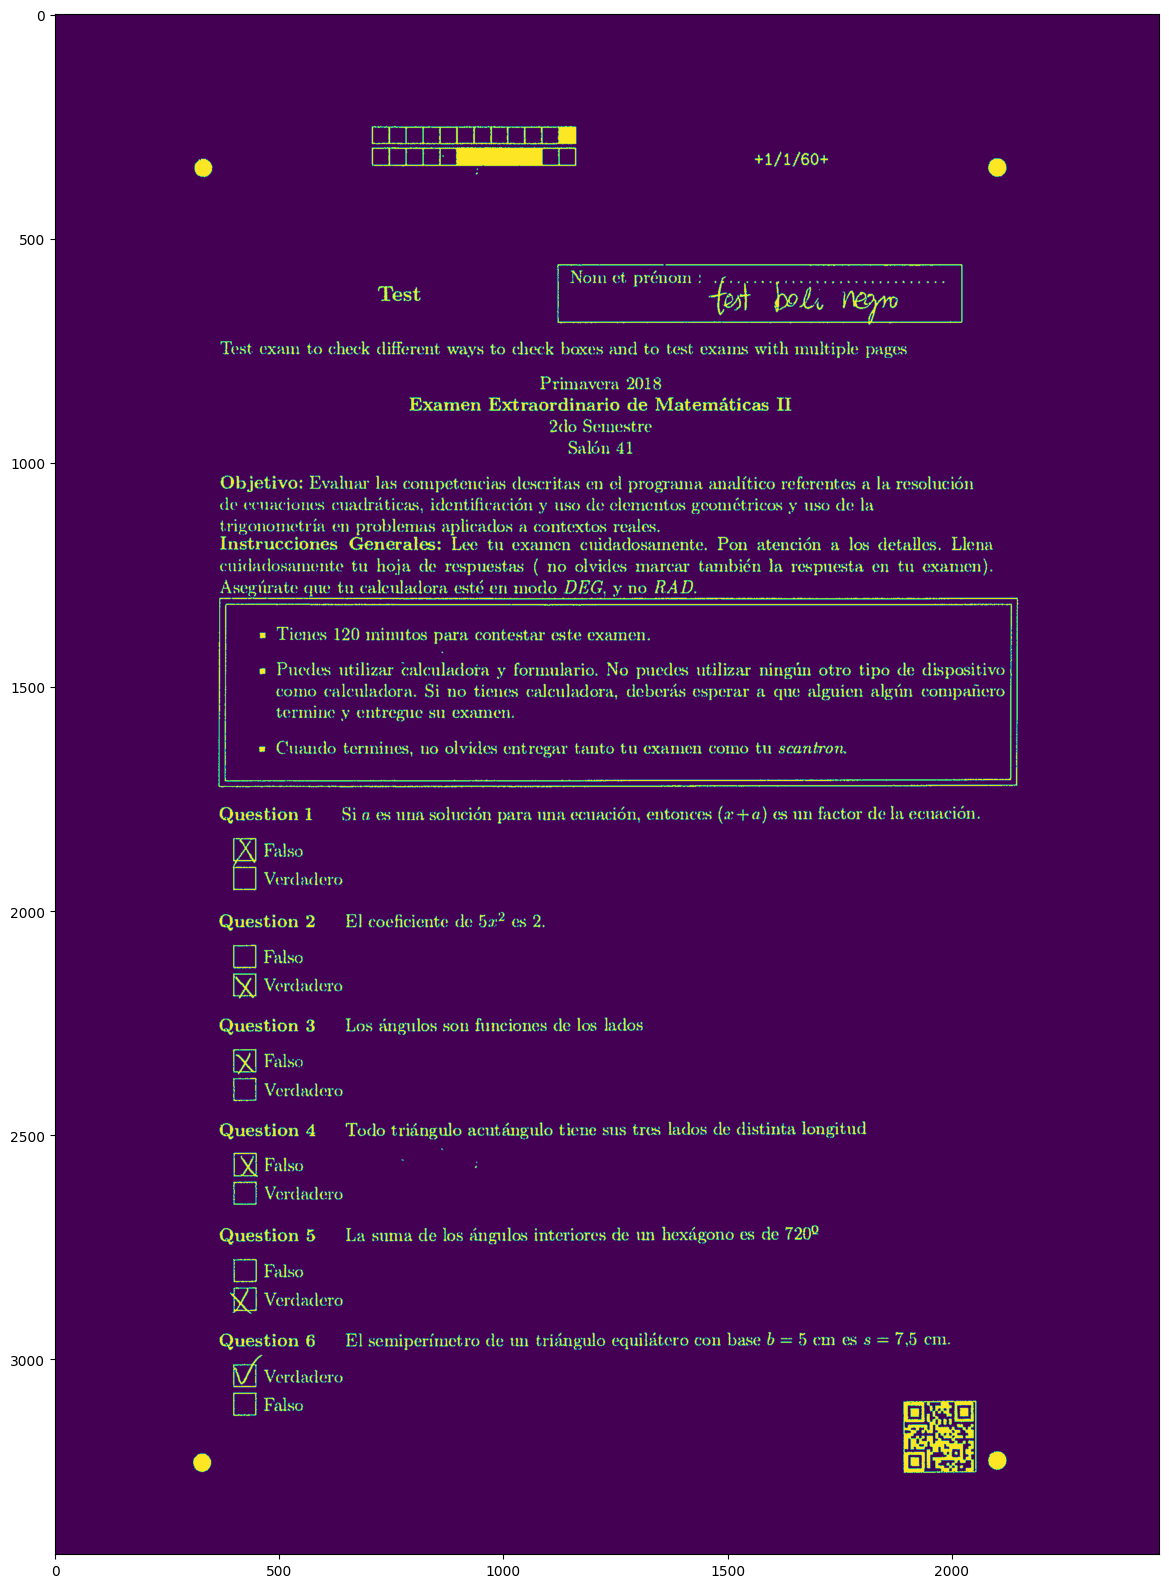

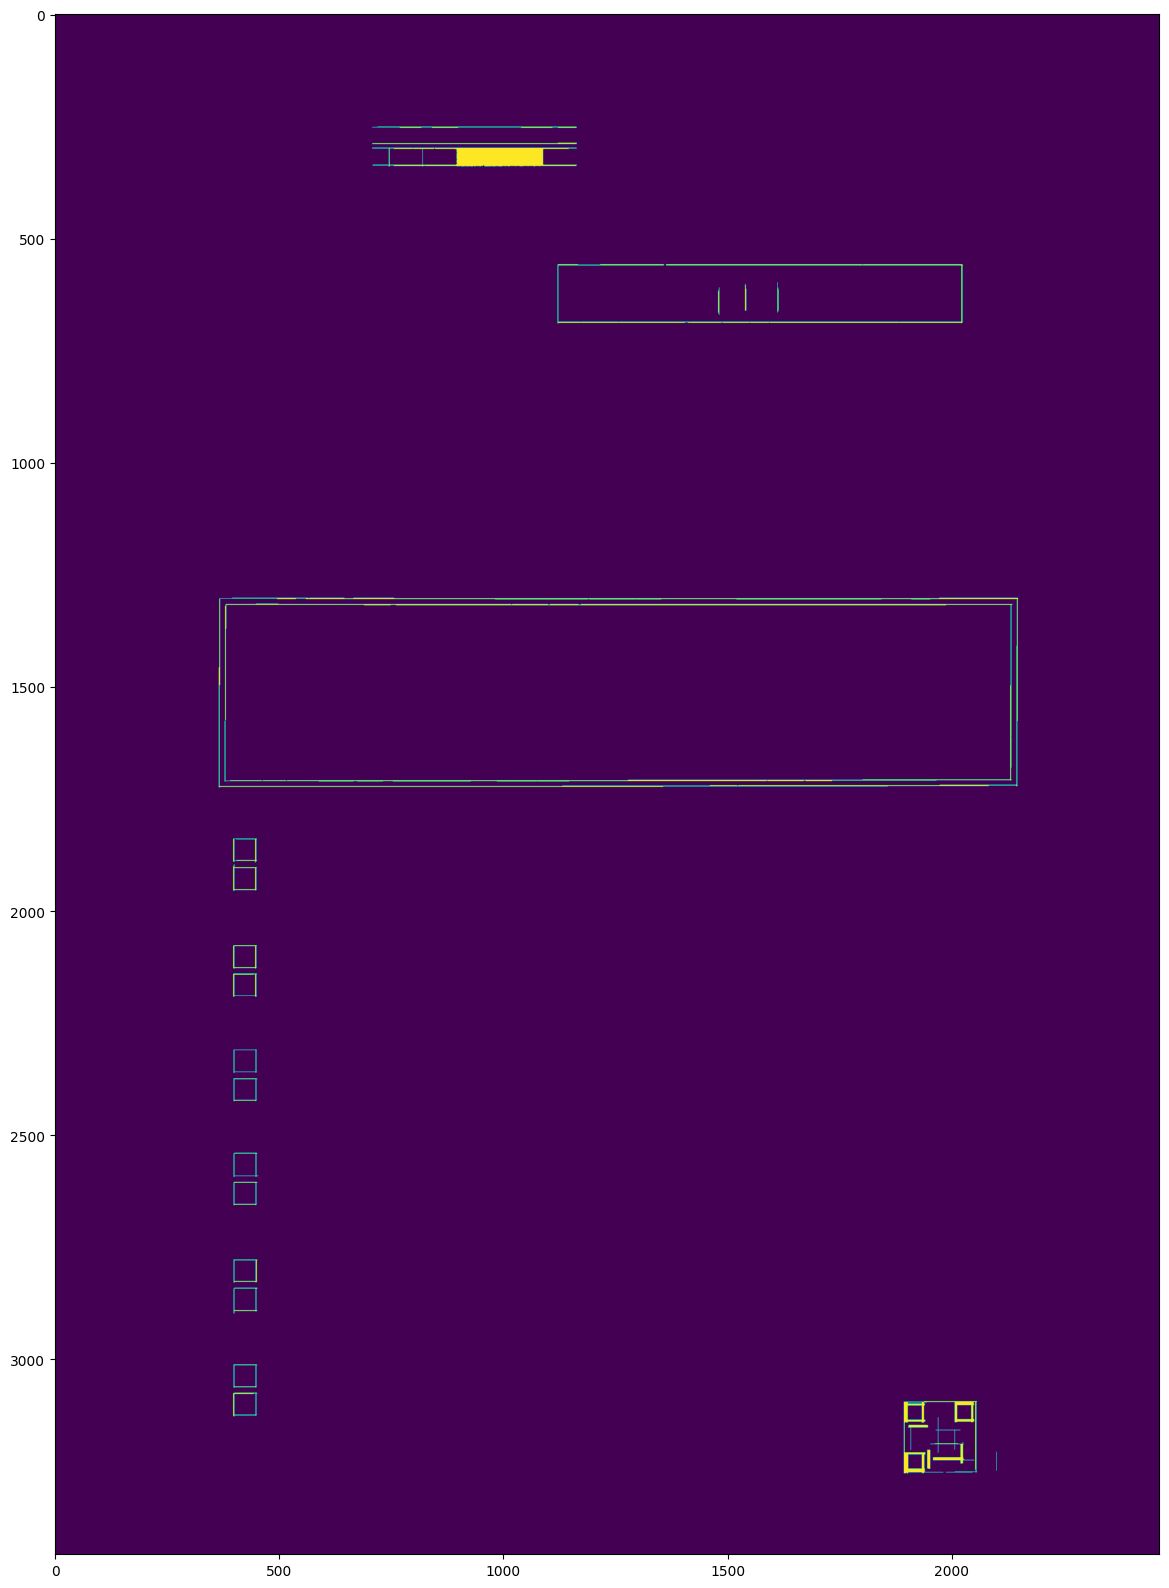

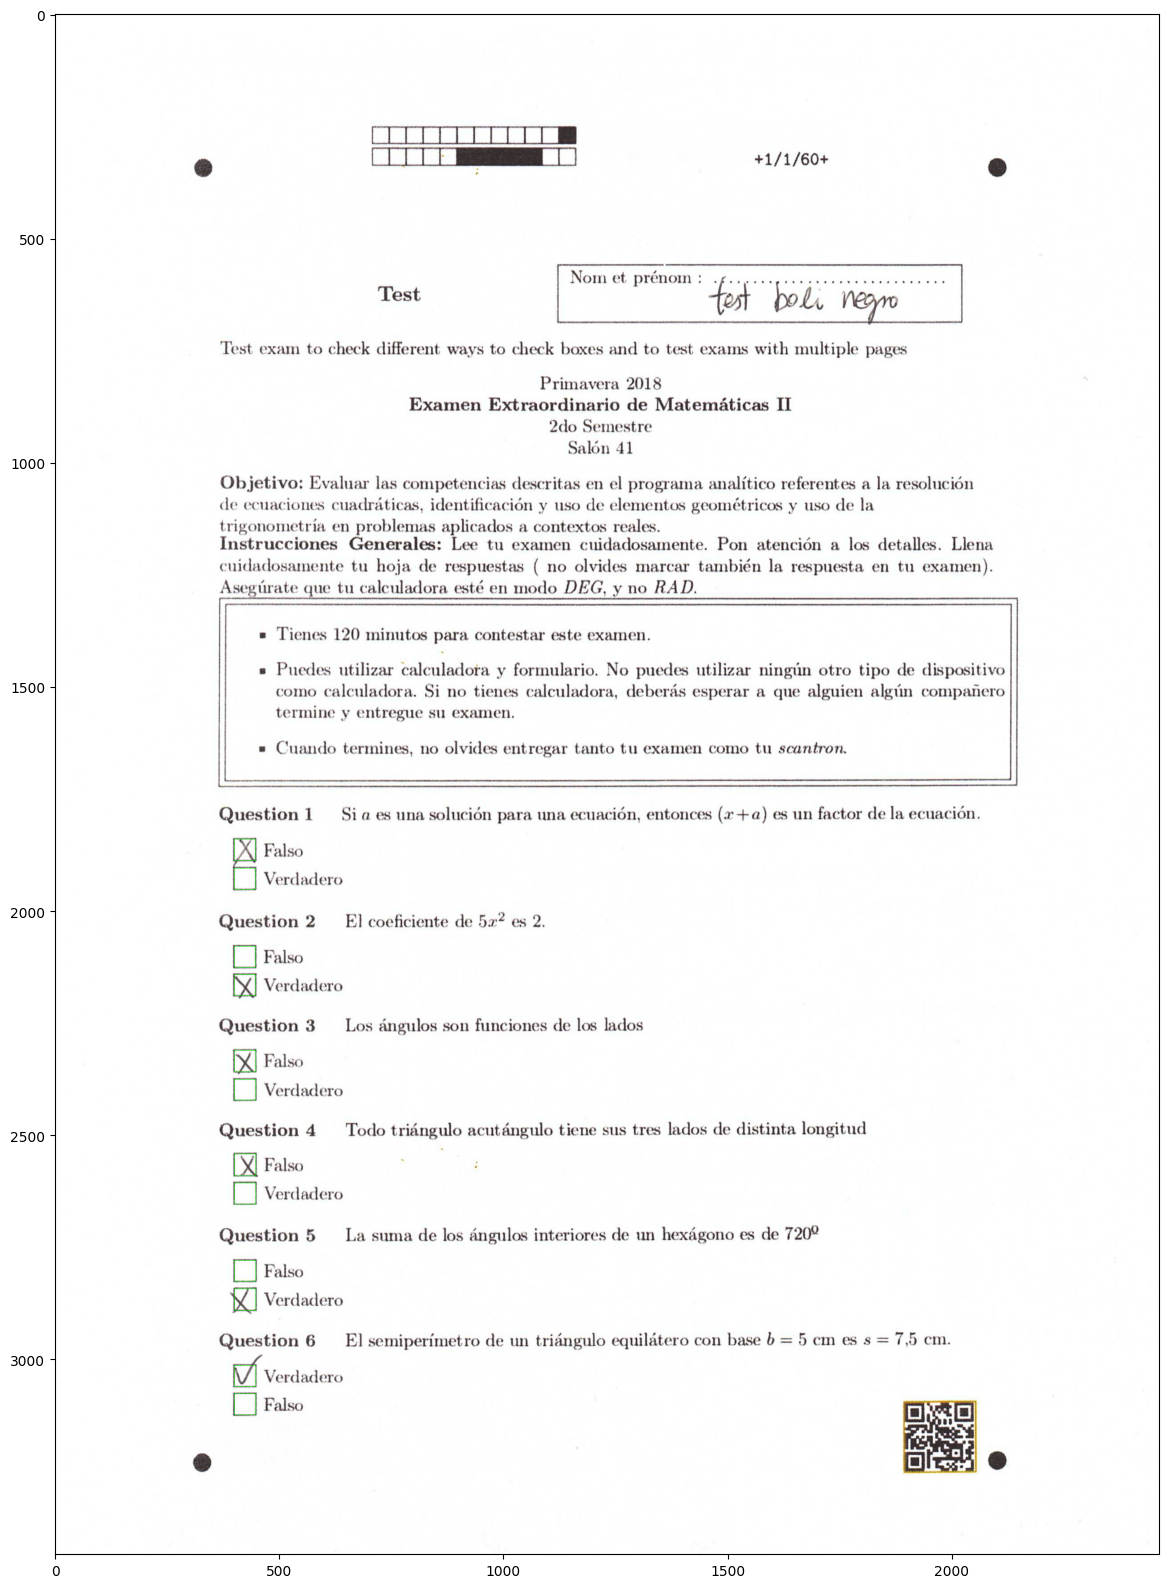

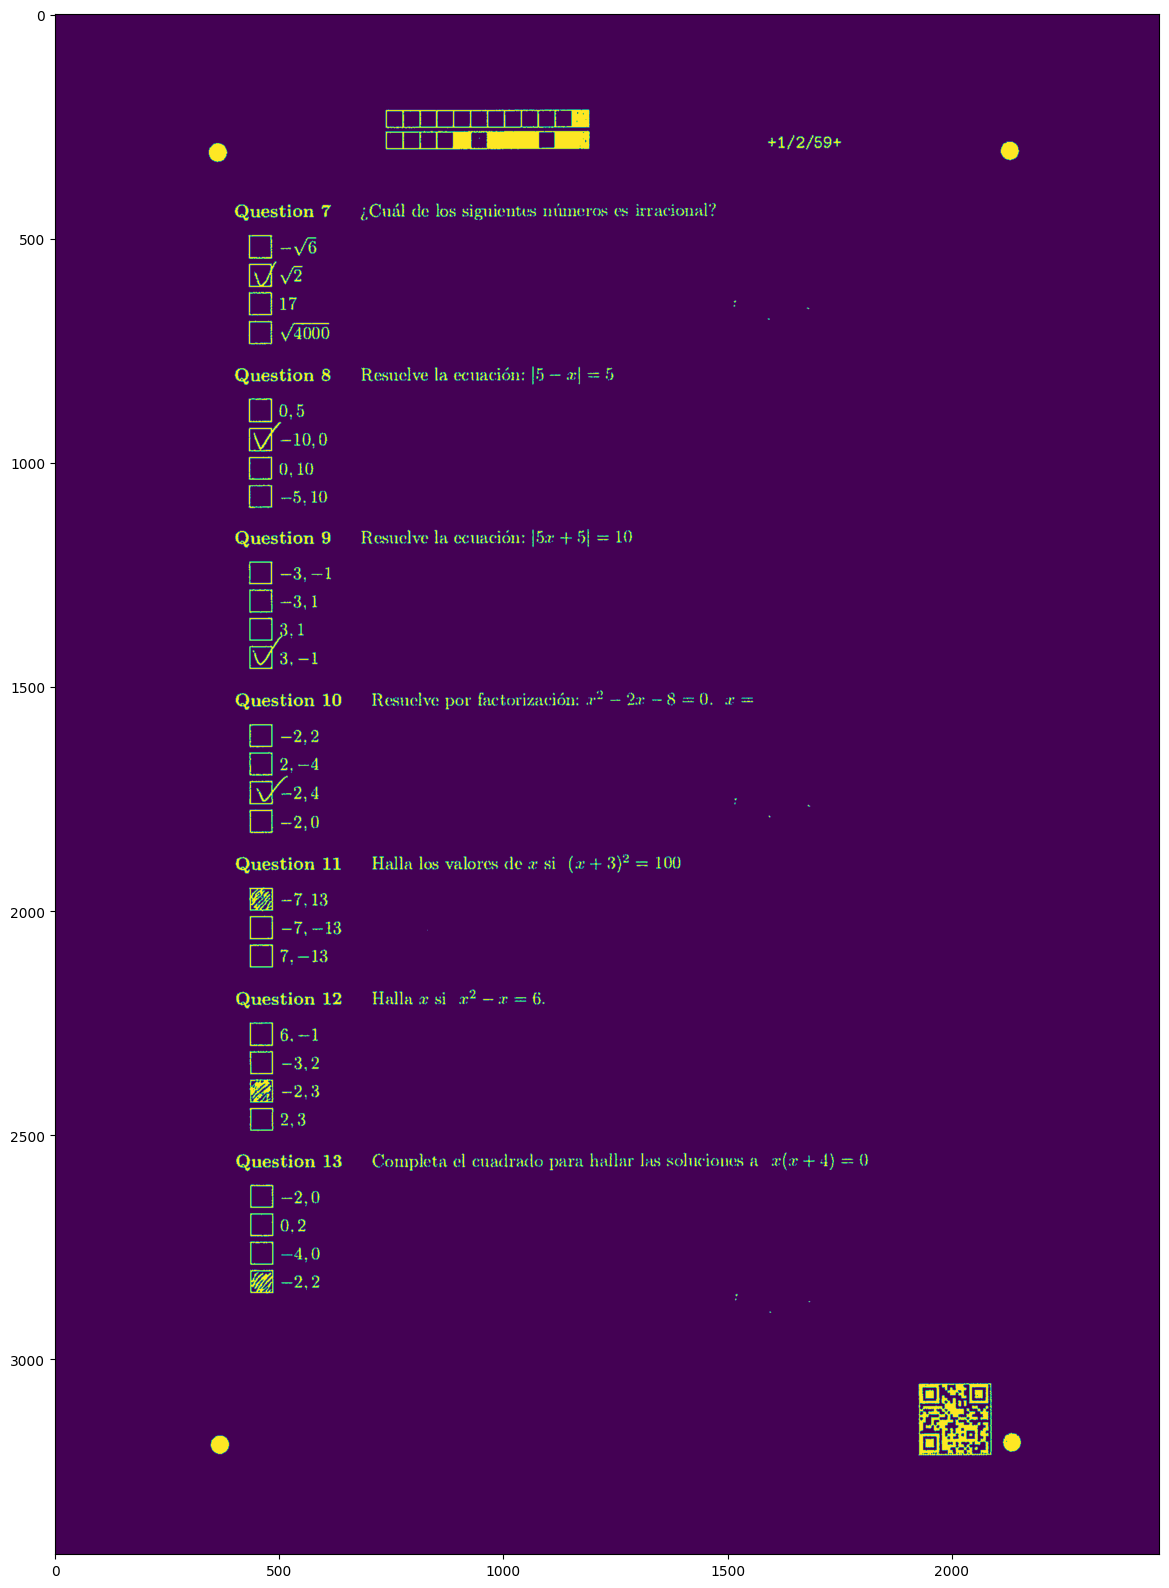

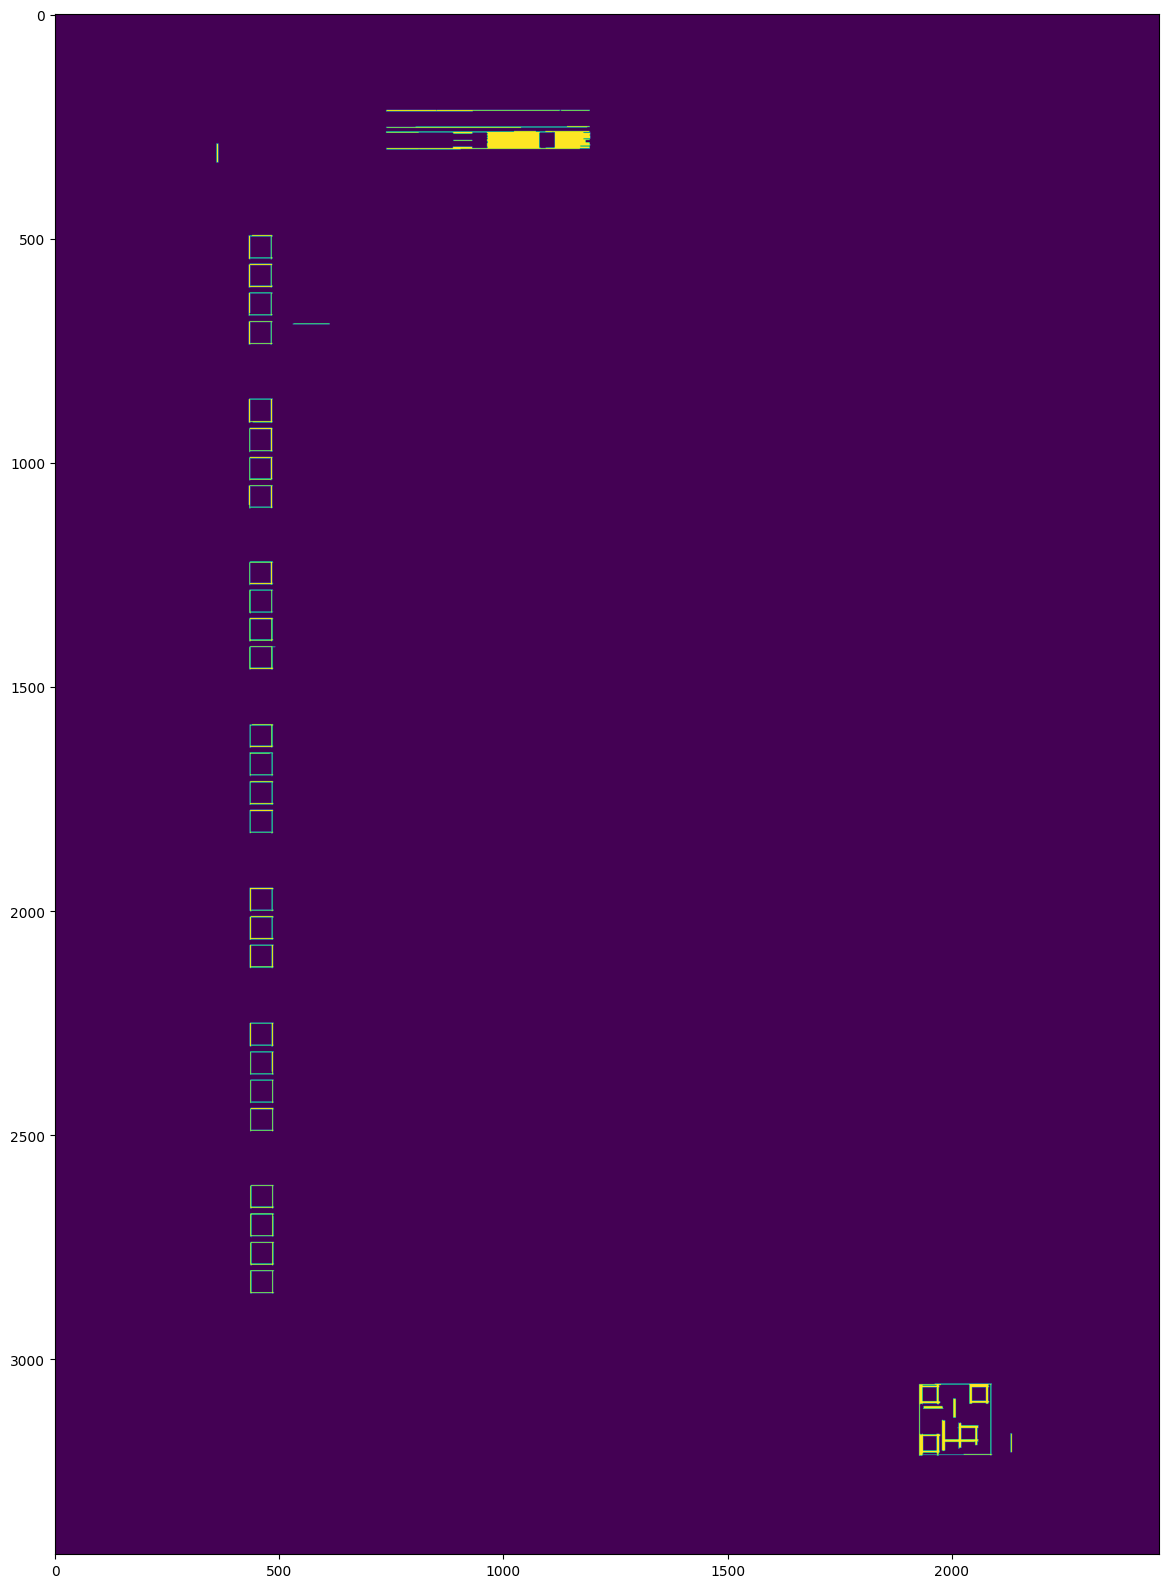

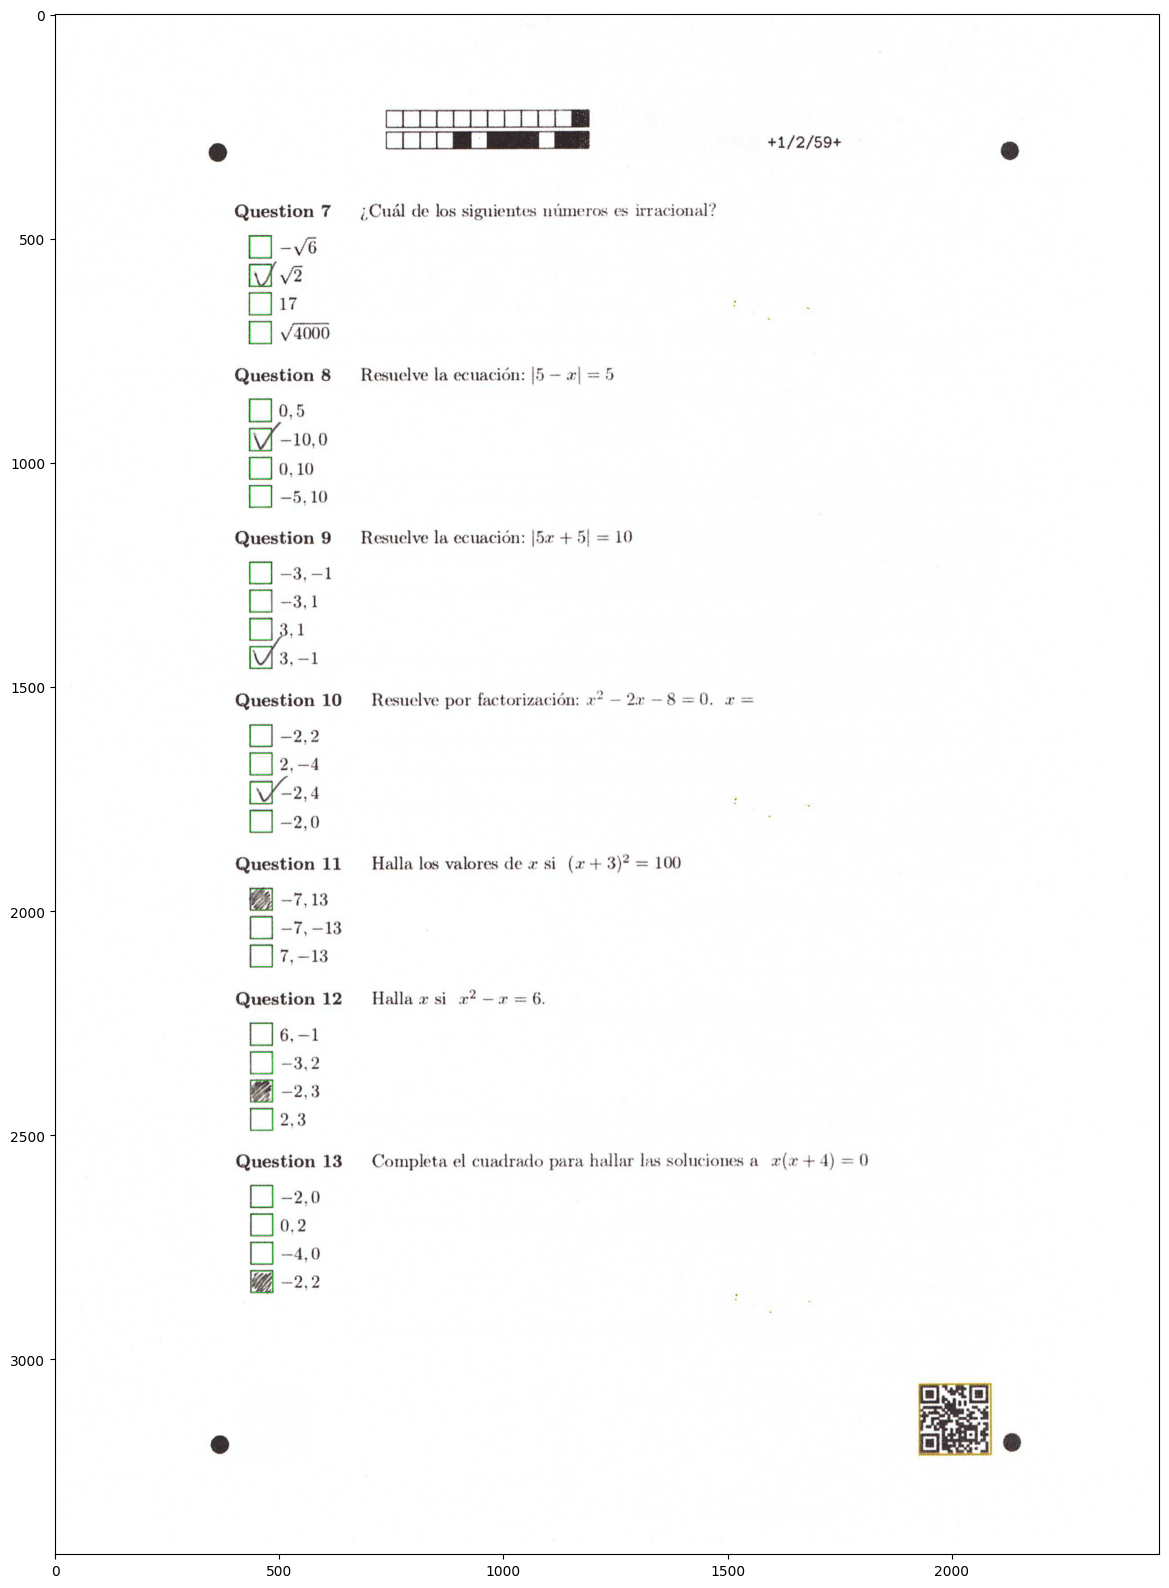

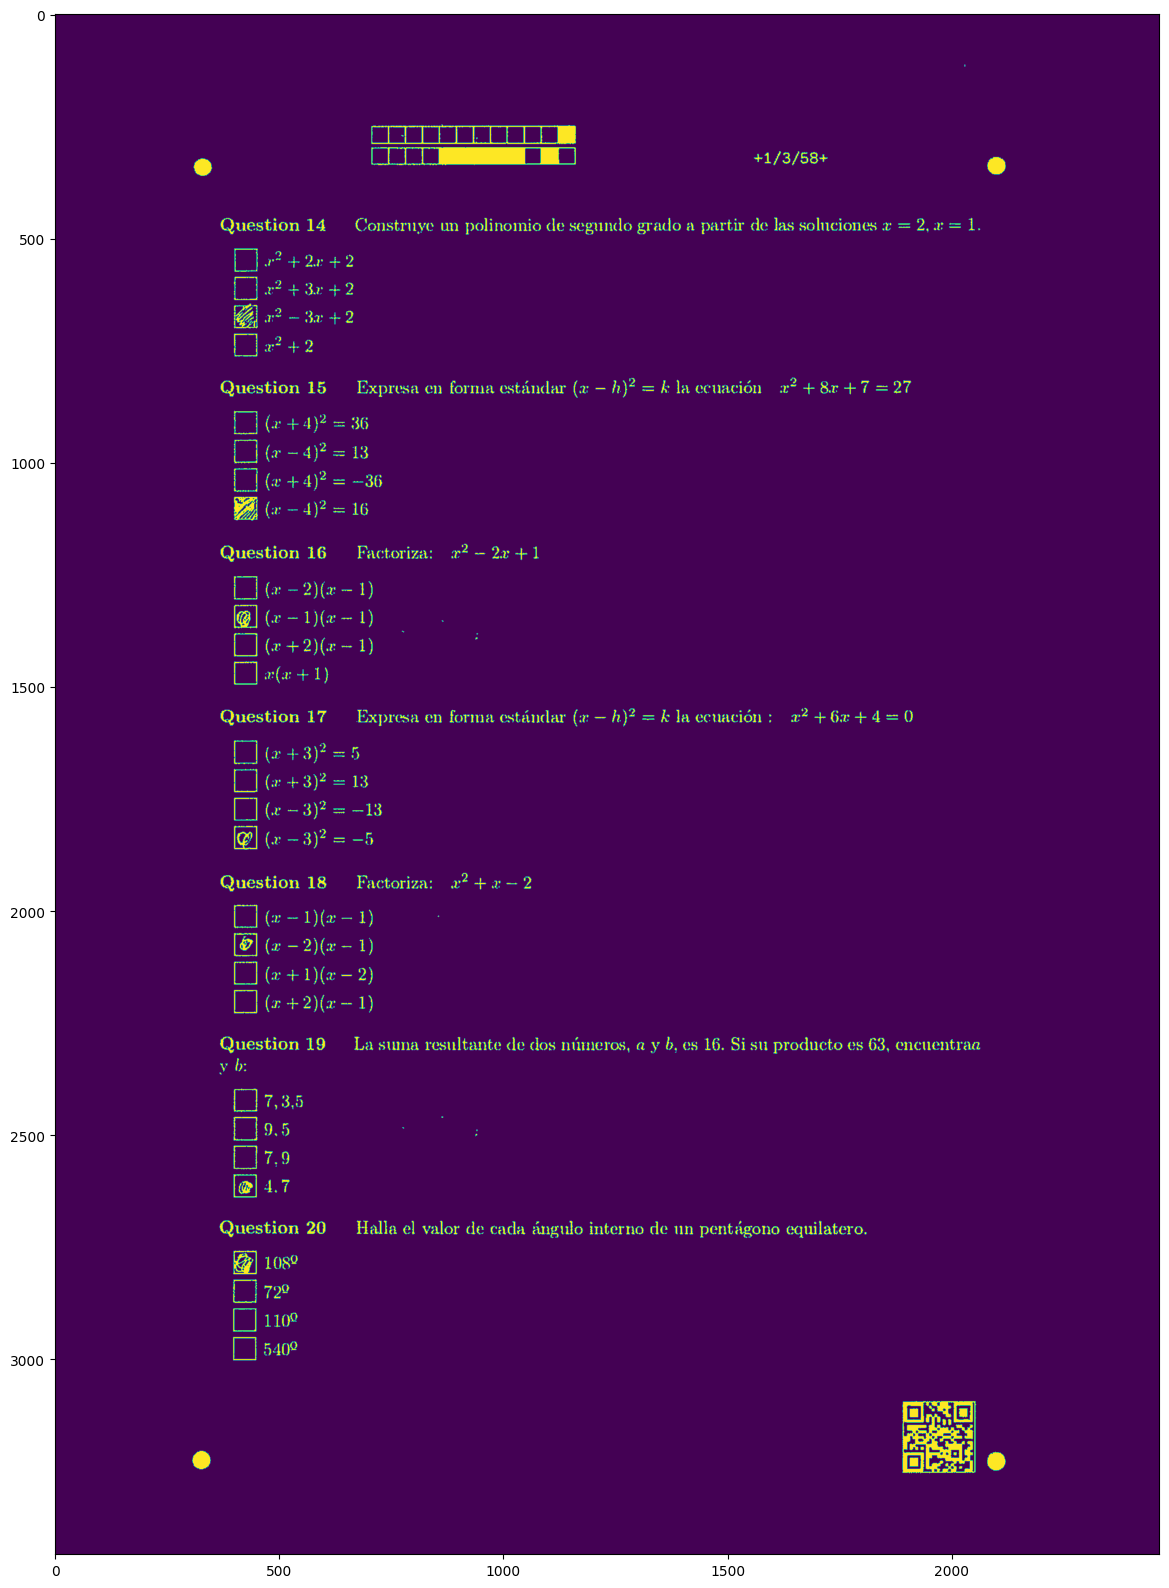

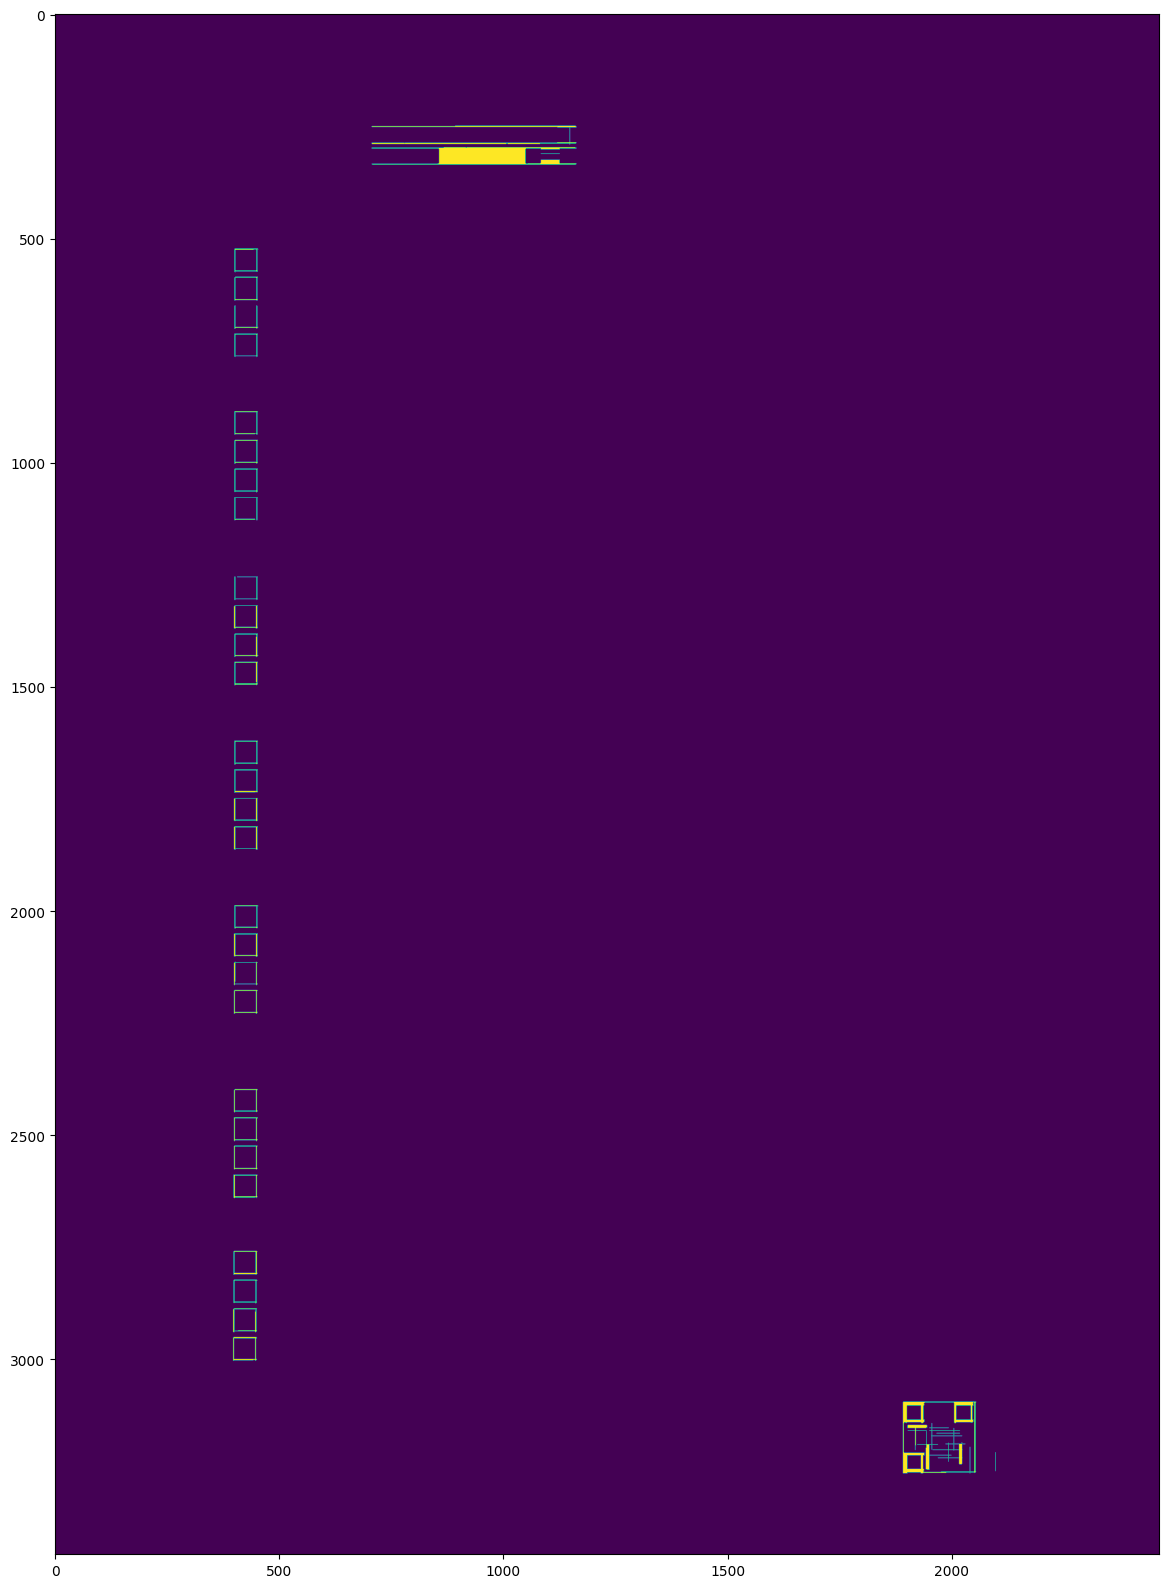

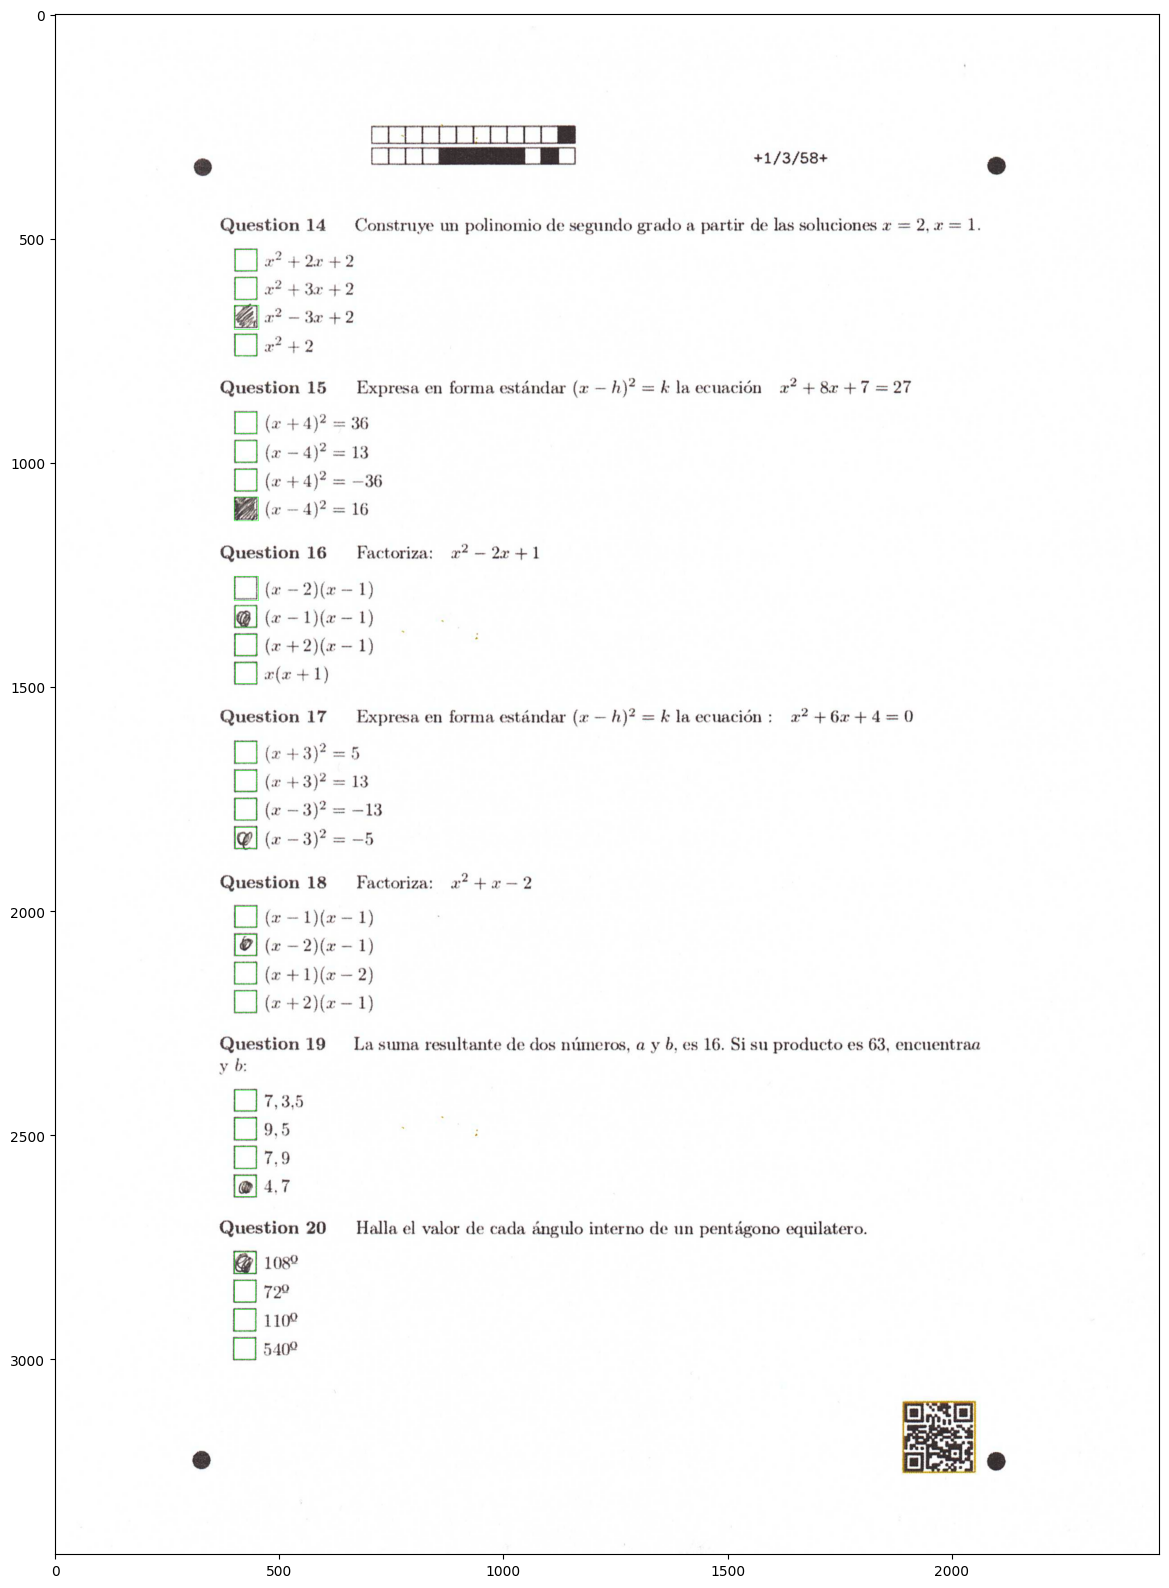

In [10]:
scan1x5 = analyse('../multiple_choice_example/scanned/scanned_11111.pdf')
scan1x5

examen con paginas desordenadas: 1, 3, 2

{'exam': 'test_qr',
 'variant': '11111',
 'num_boxes': 67,
 'boxes': [{'stats': [400, 1840, 46, 48], 'page': '1', 'is_marked': True},
  {'stats': [400, 1905, 46, 47], 'page': '1', 'is_marked': False},
  {'stats': [400, 2079, 46, 47], 'page': '1', 'is_marked': False},
  {'stats': [400, 2142, 46, 47], 'page': '1', 'is_marked': True},
  {'stats': [400, 2311, 47, 48], 'page': '1', 'is_marked': True},
  {'stats': [400, 2376, 47, 46], 'page': '1', 'is_marked': False},
  {'stats': [400, 2542, 47, 49], 'page': '1', 'is_marked': True},
  {'stats': [400, 2607, 47, 47], 'page': '1', 'is_marked': False},
  {'stats': [400, 2780, 47, 46], 'page': '1', 'is_marked': False},
  {'stats': [400, 2843, 47, 48], 'page': '1', 'is_marked': True},
  {'stats': [400, 3014, 47, 47], 'page': '1', 'is_marked': True},
  {'stats': [400, 3077, 47, 47], 'page': '1', 'is_marked': False},
  {'stats': [435, 496, 46, 47], 'page': '2', 'is_marked': False},
  {'stats': [435, 560, 46, 46], 'page': '2', 'is_marked': True},
  {

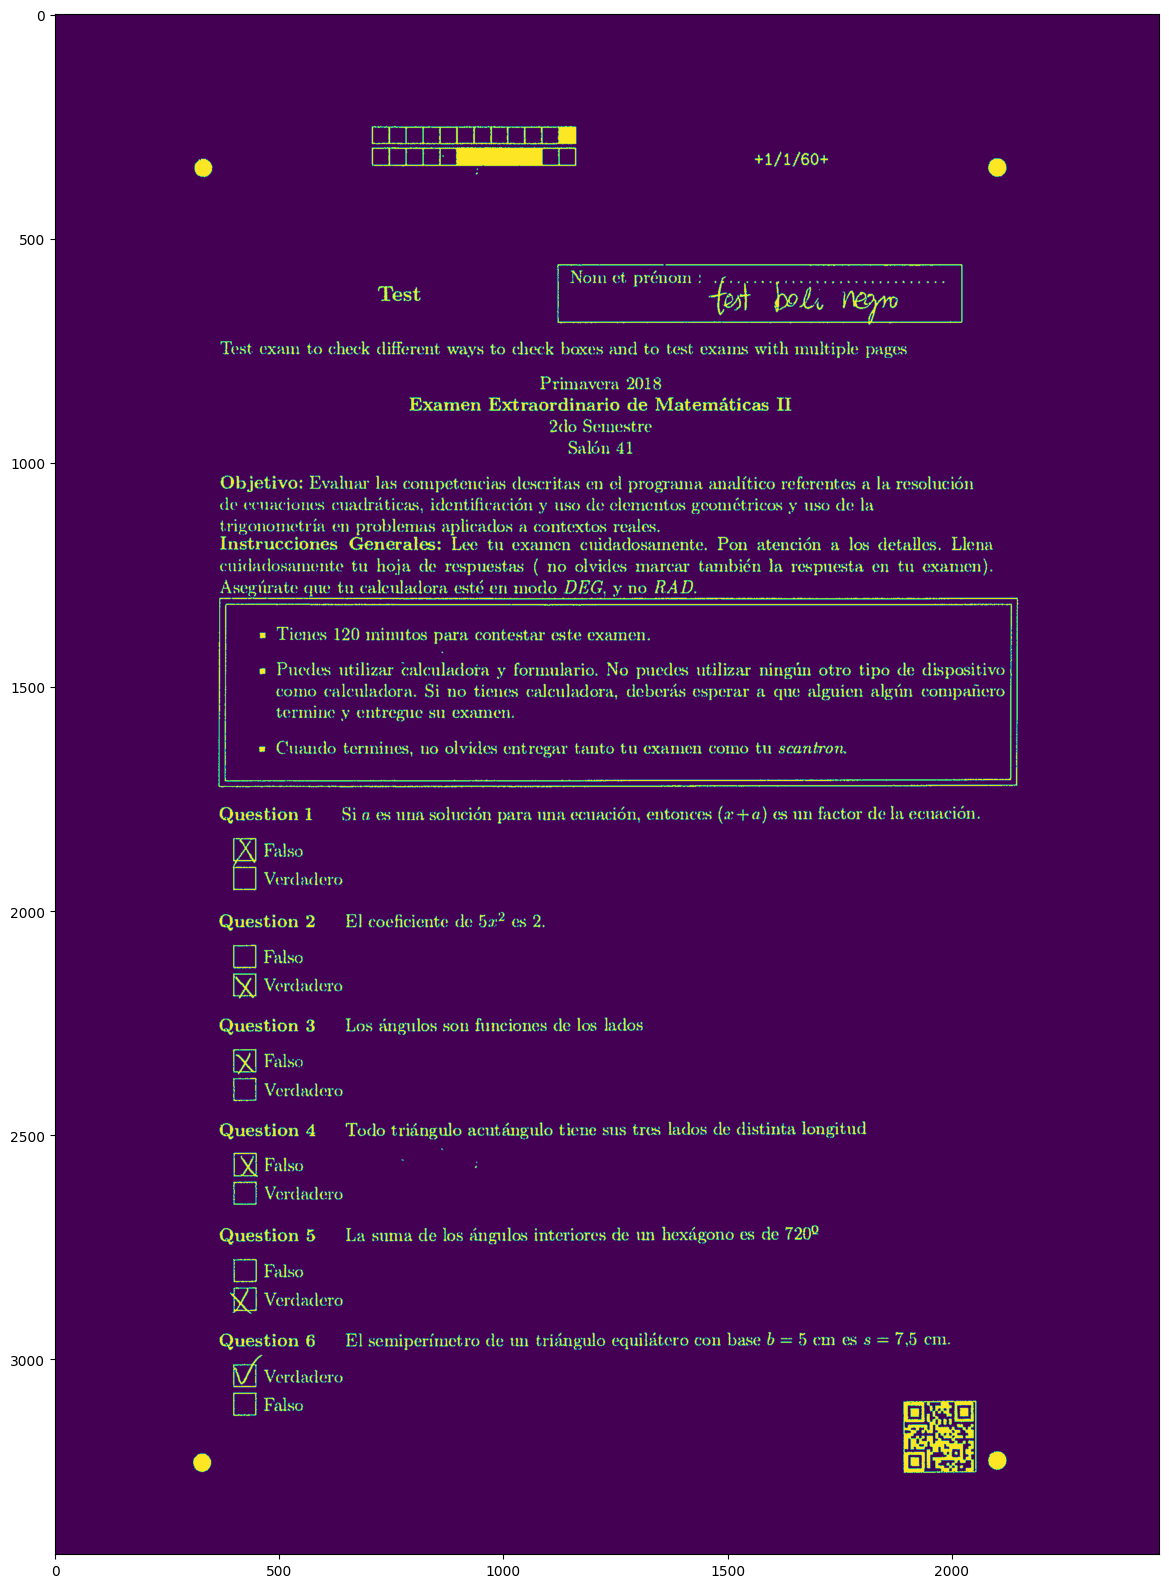

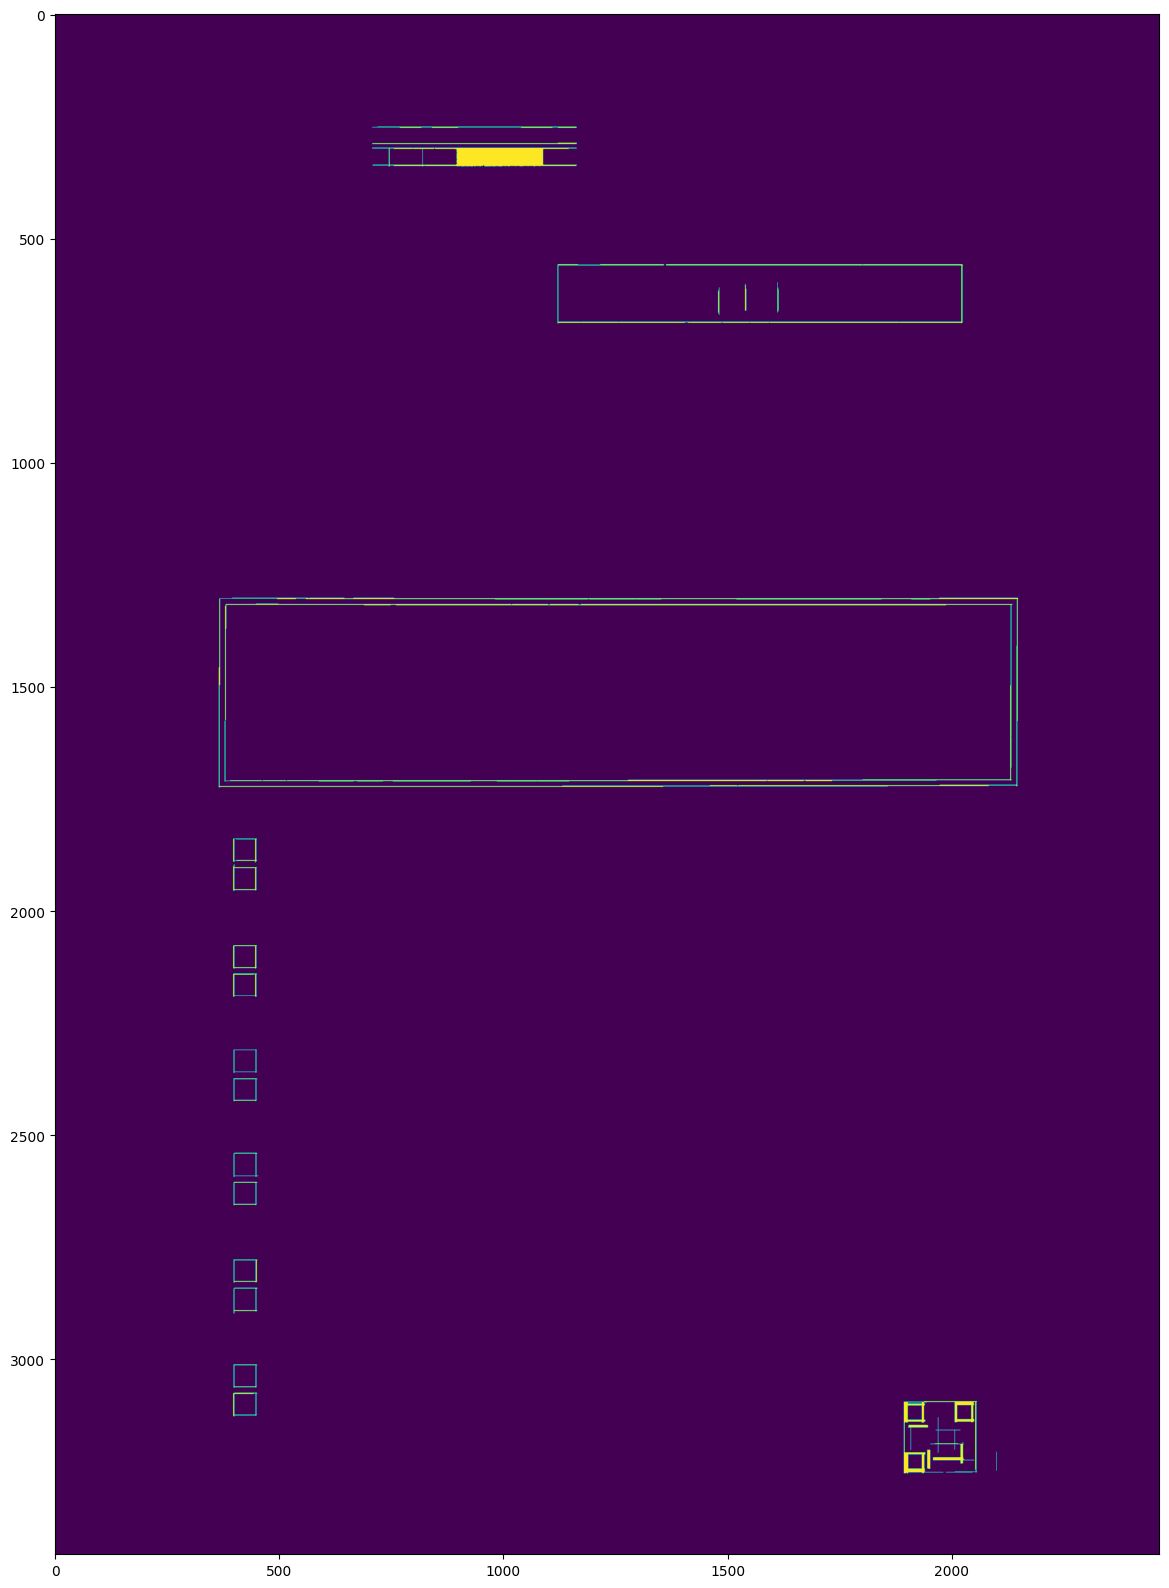

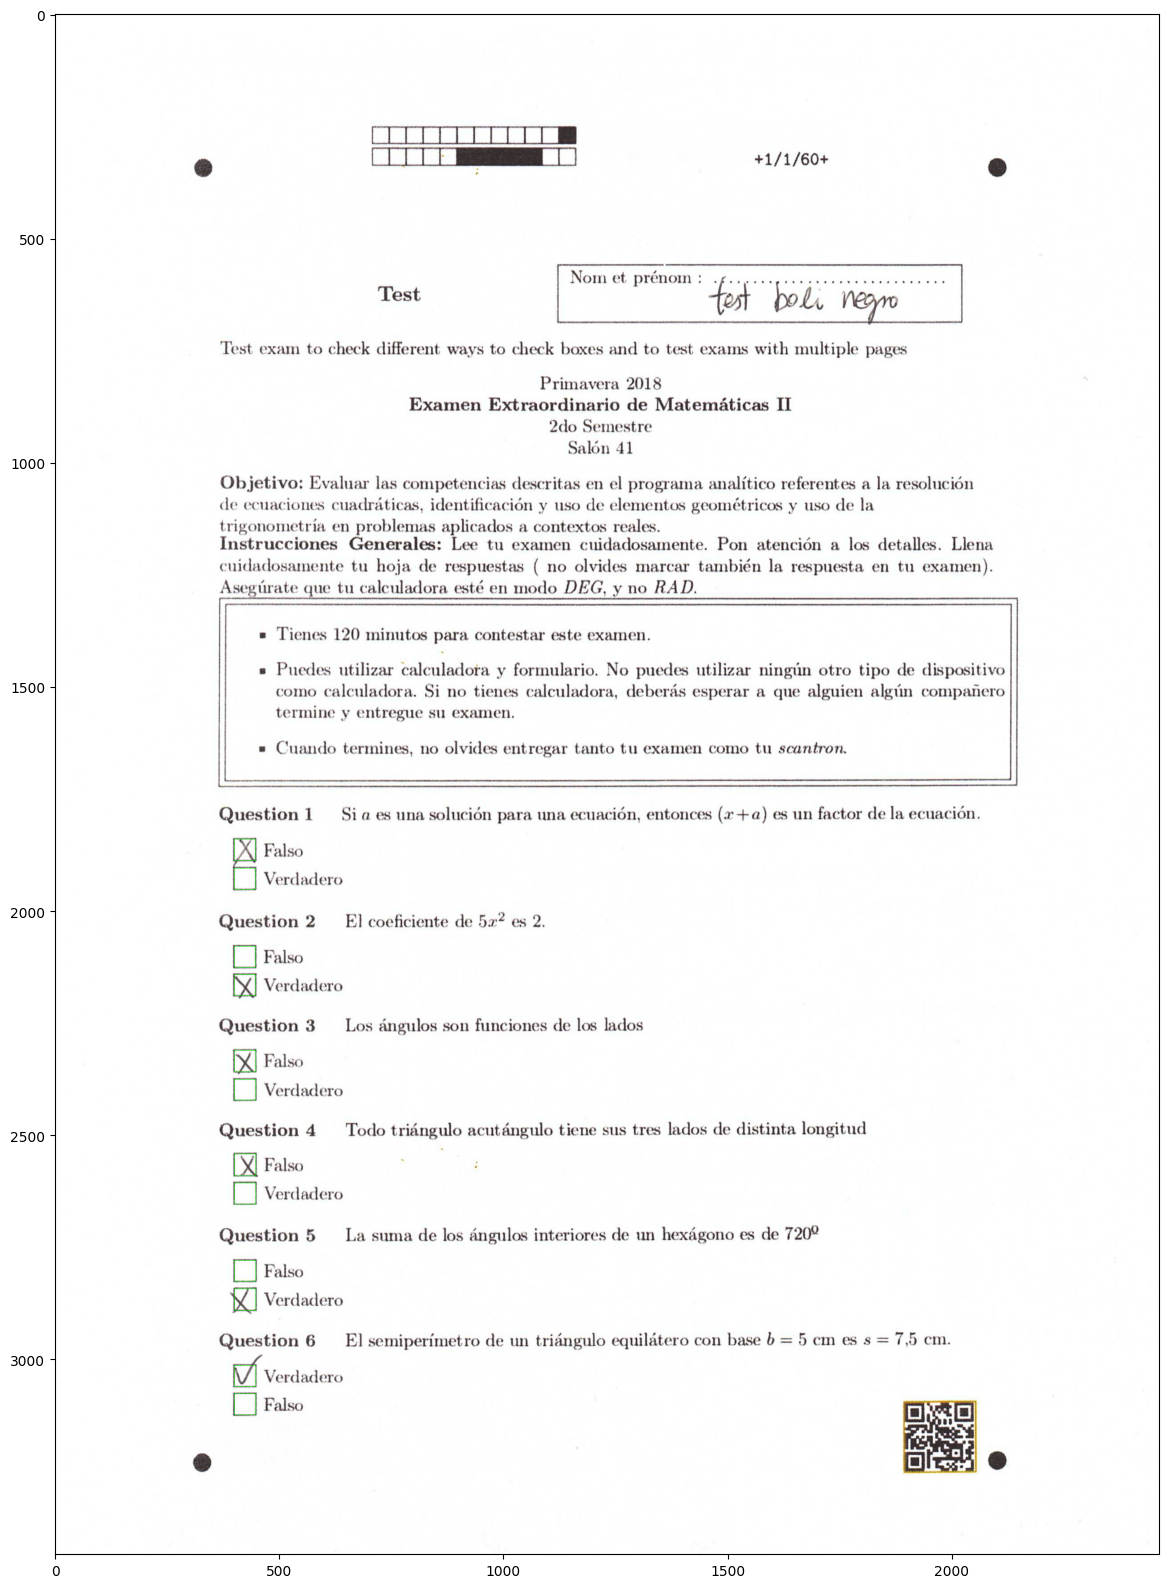

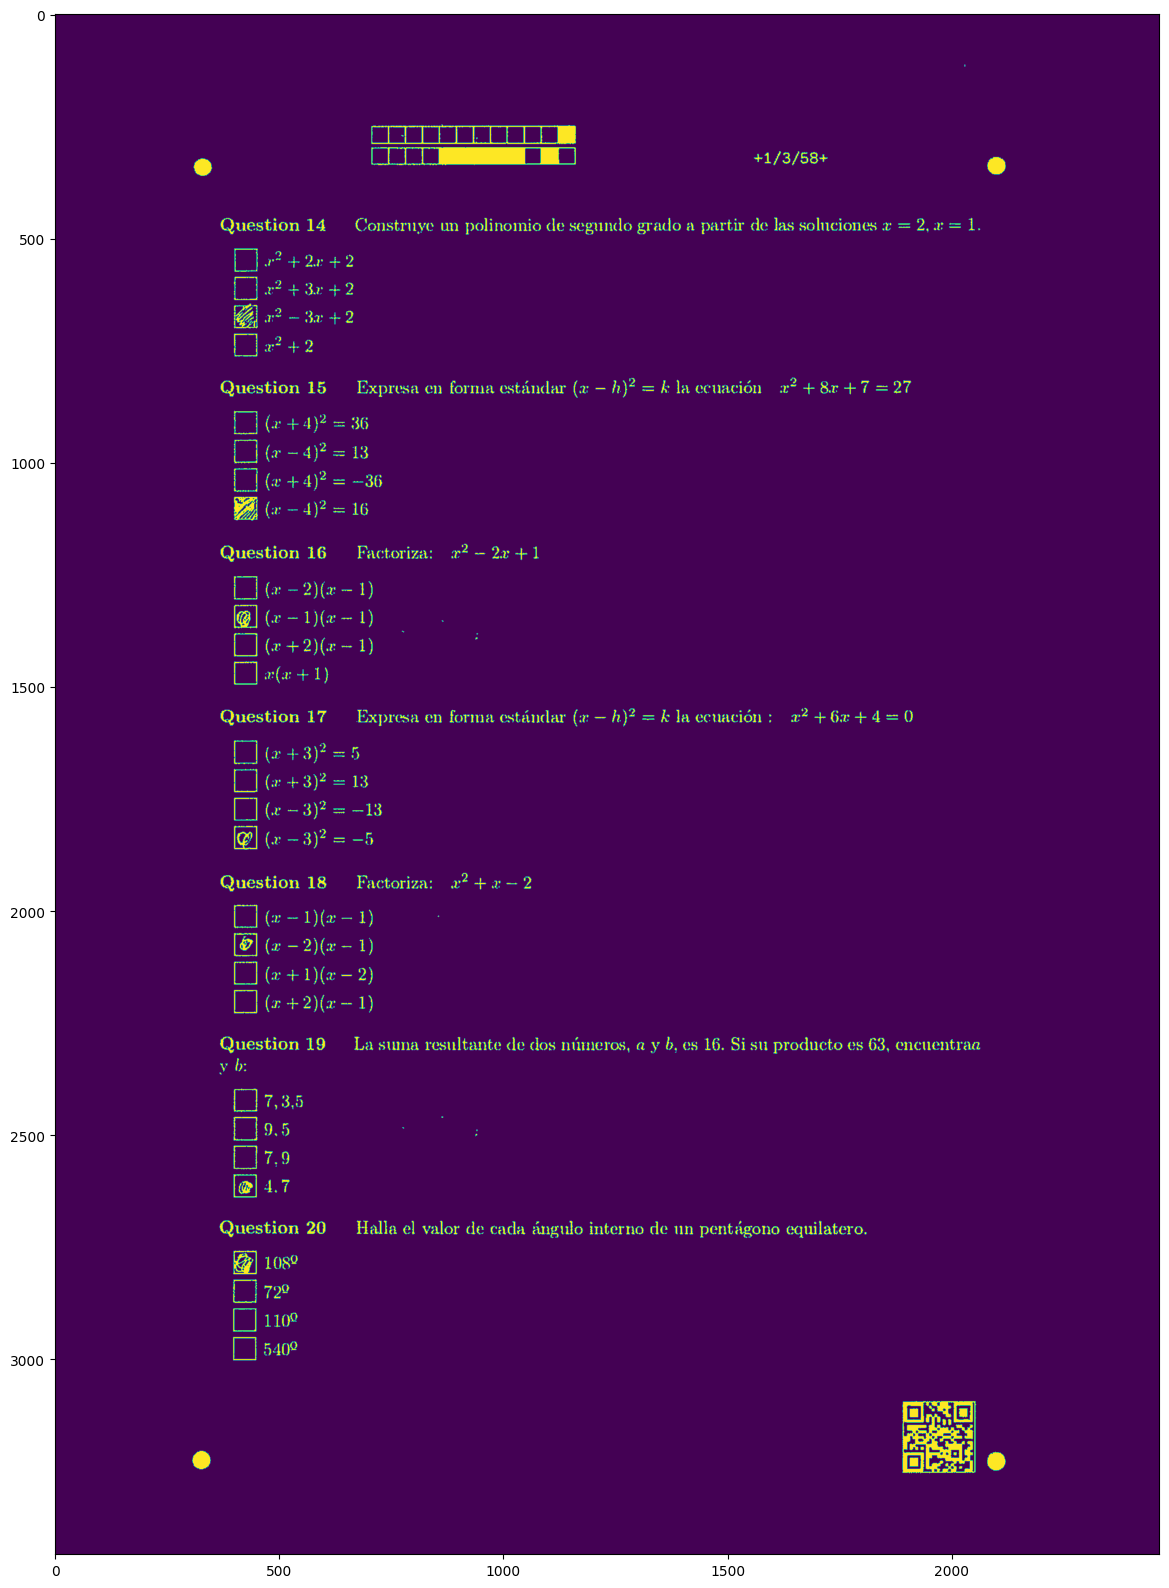

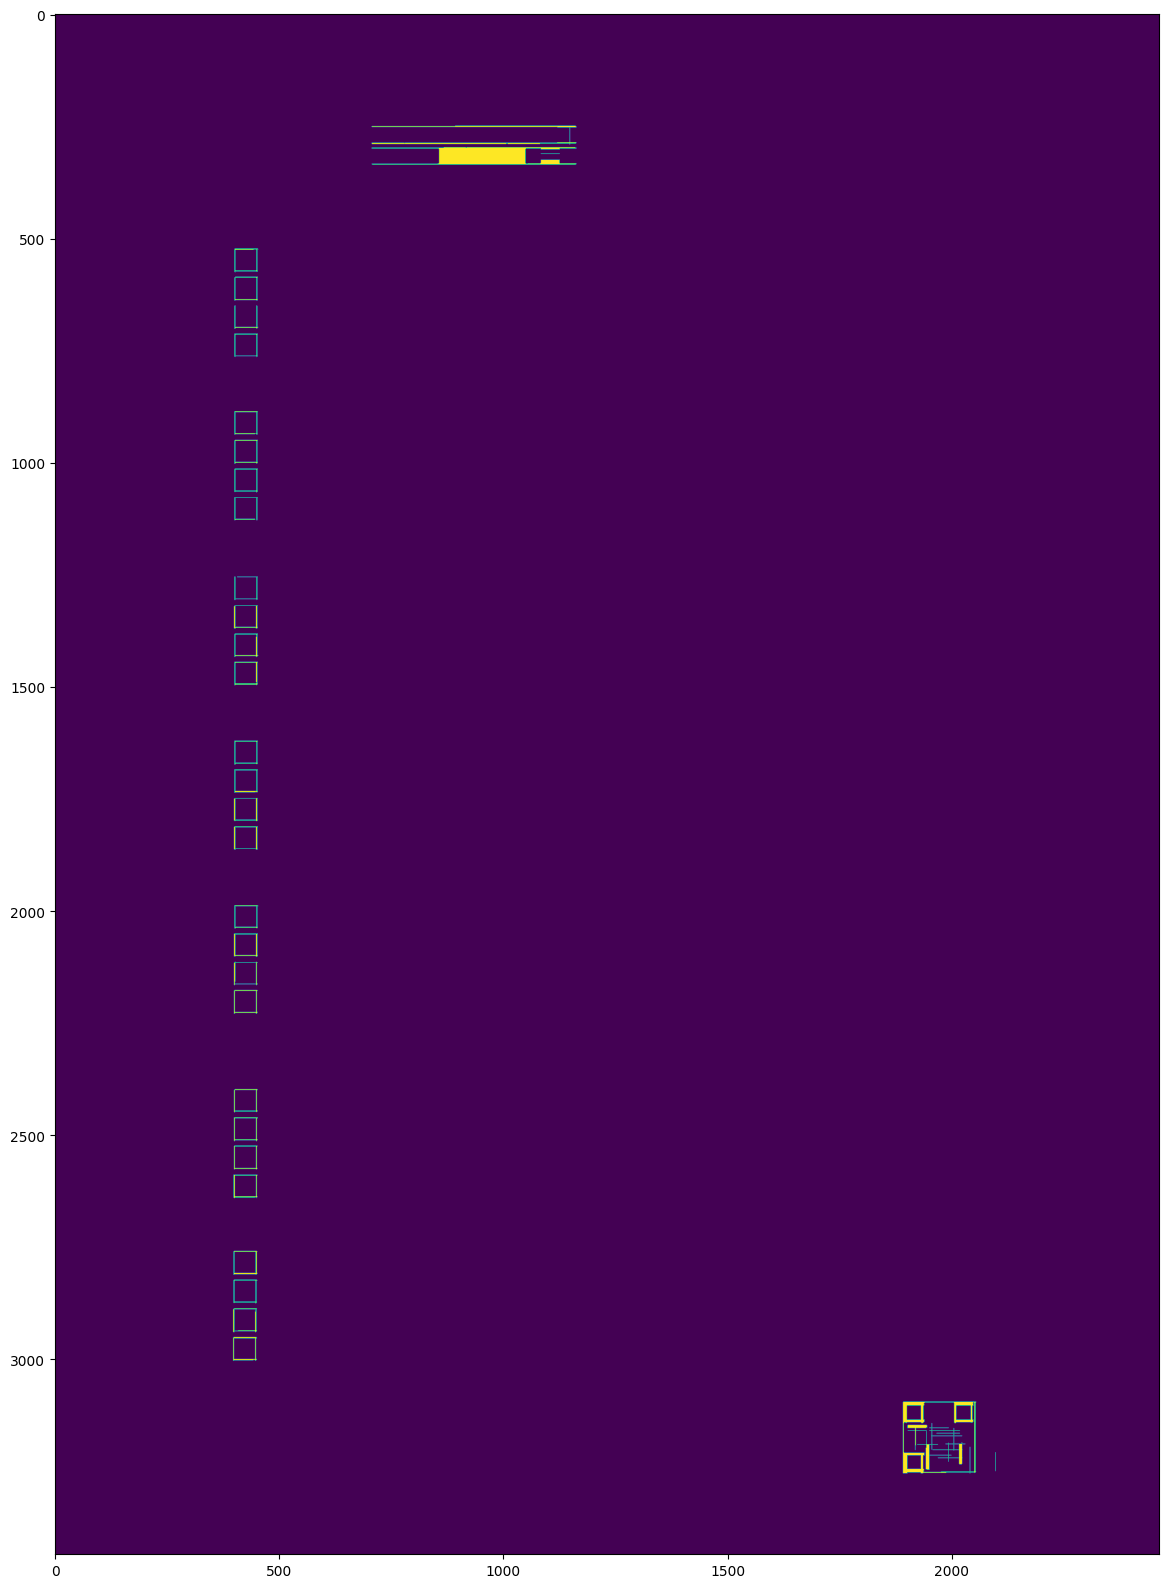

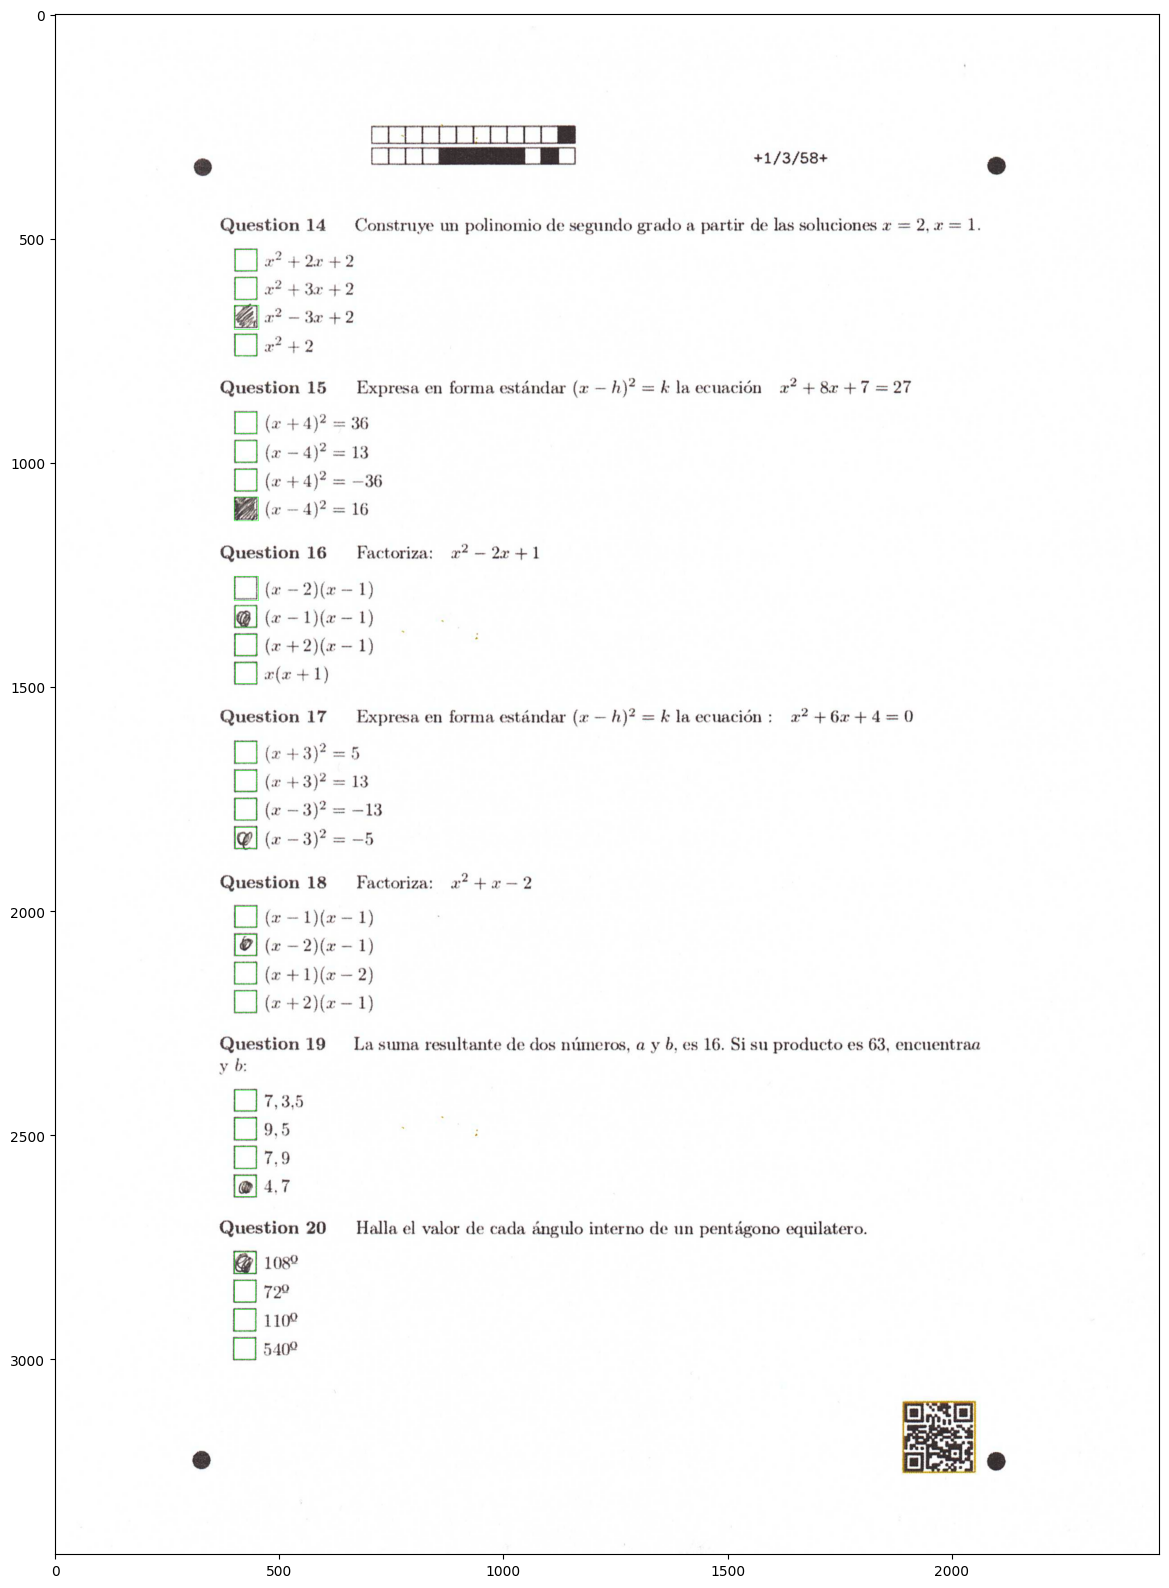

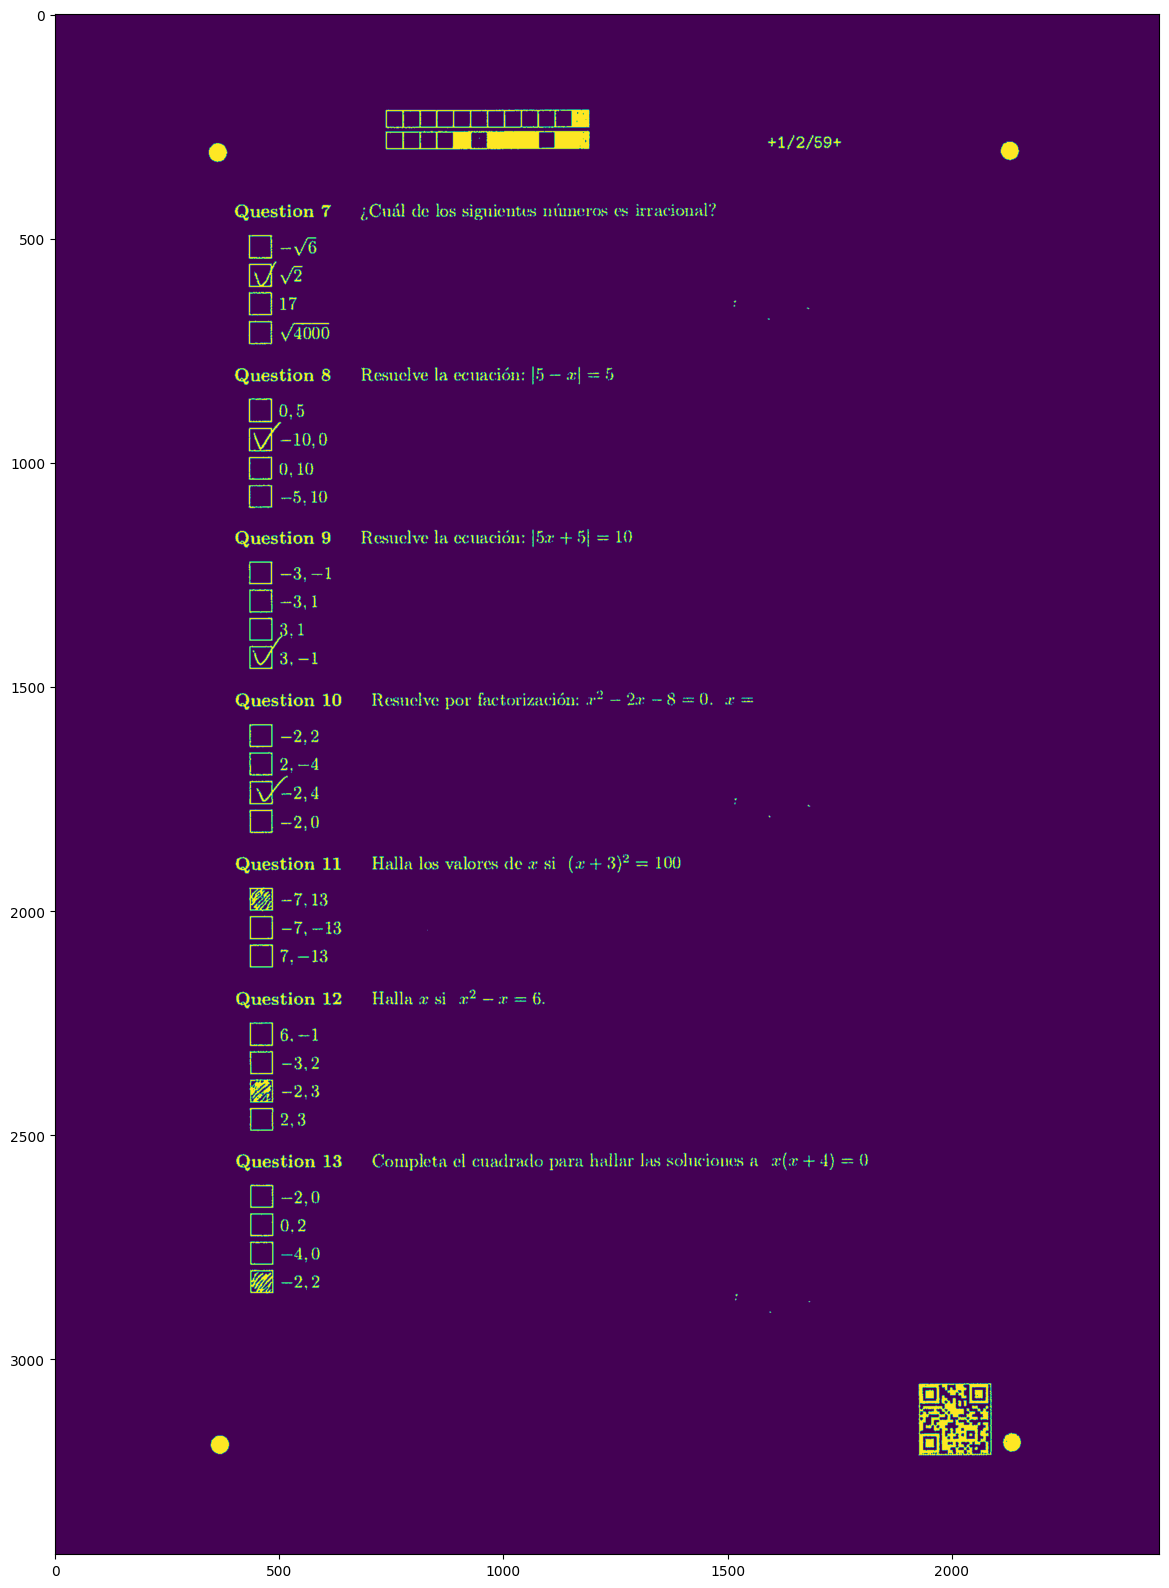

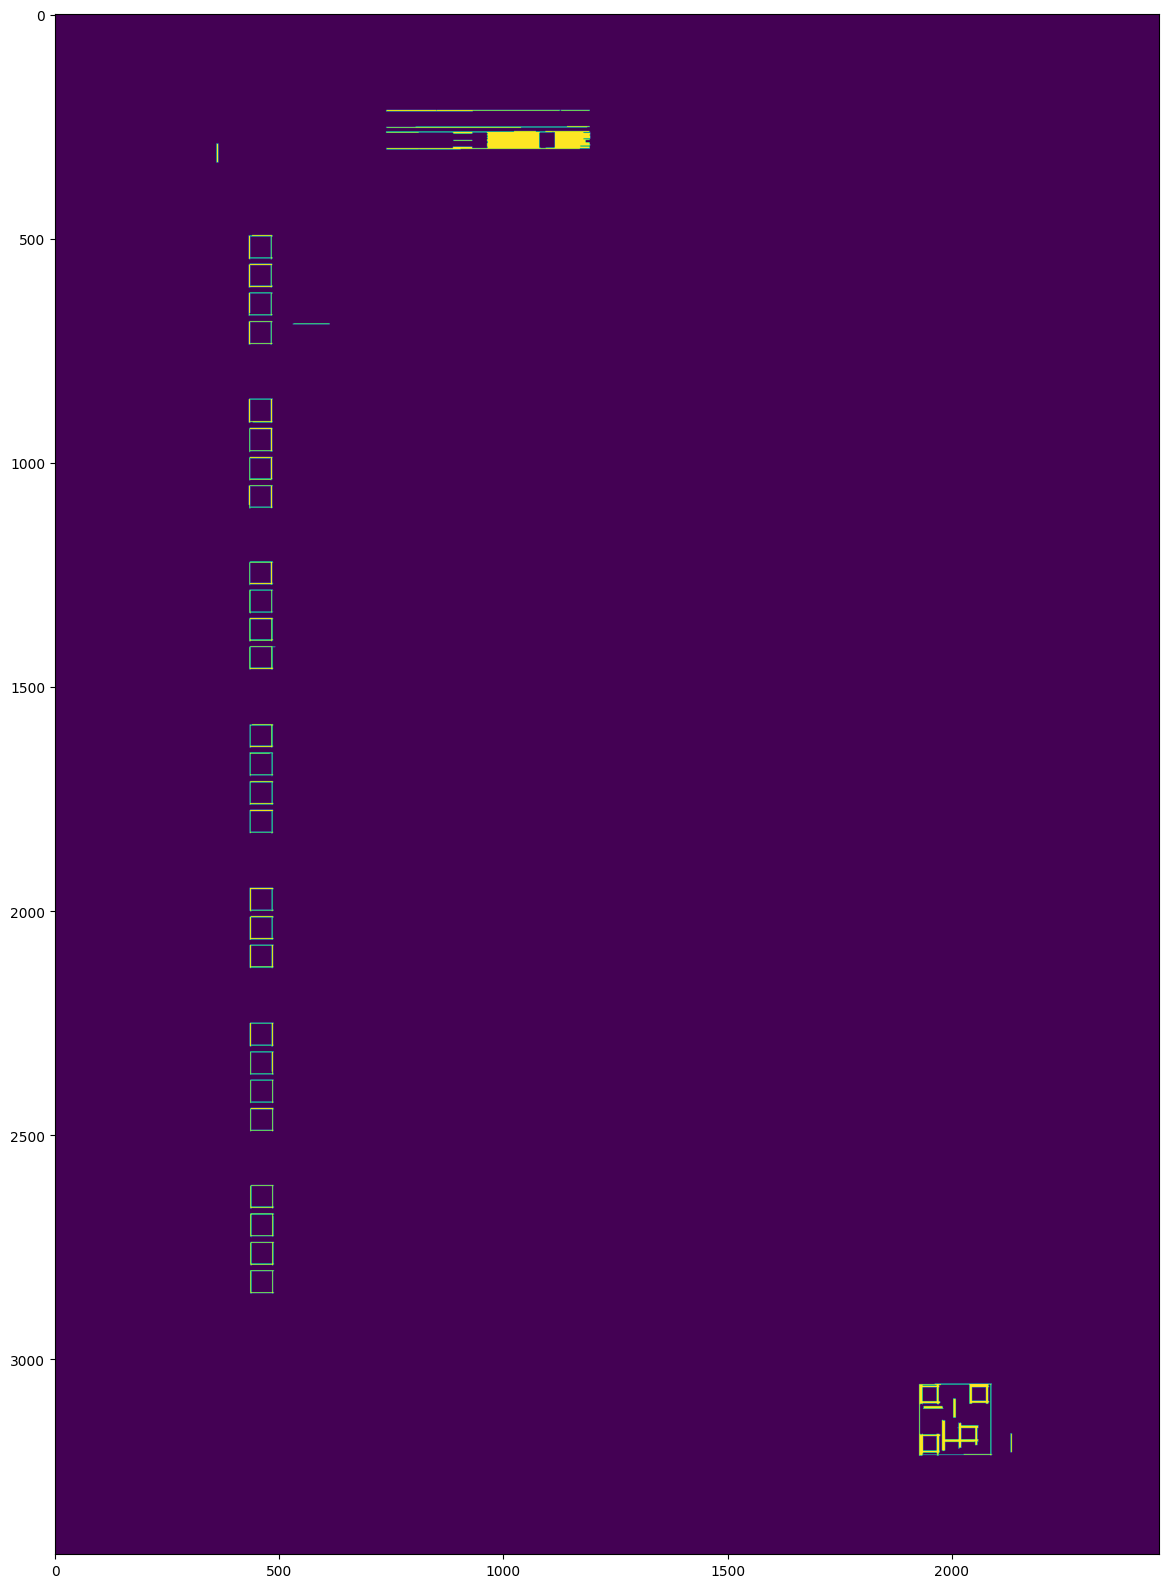

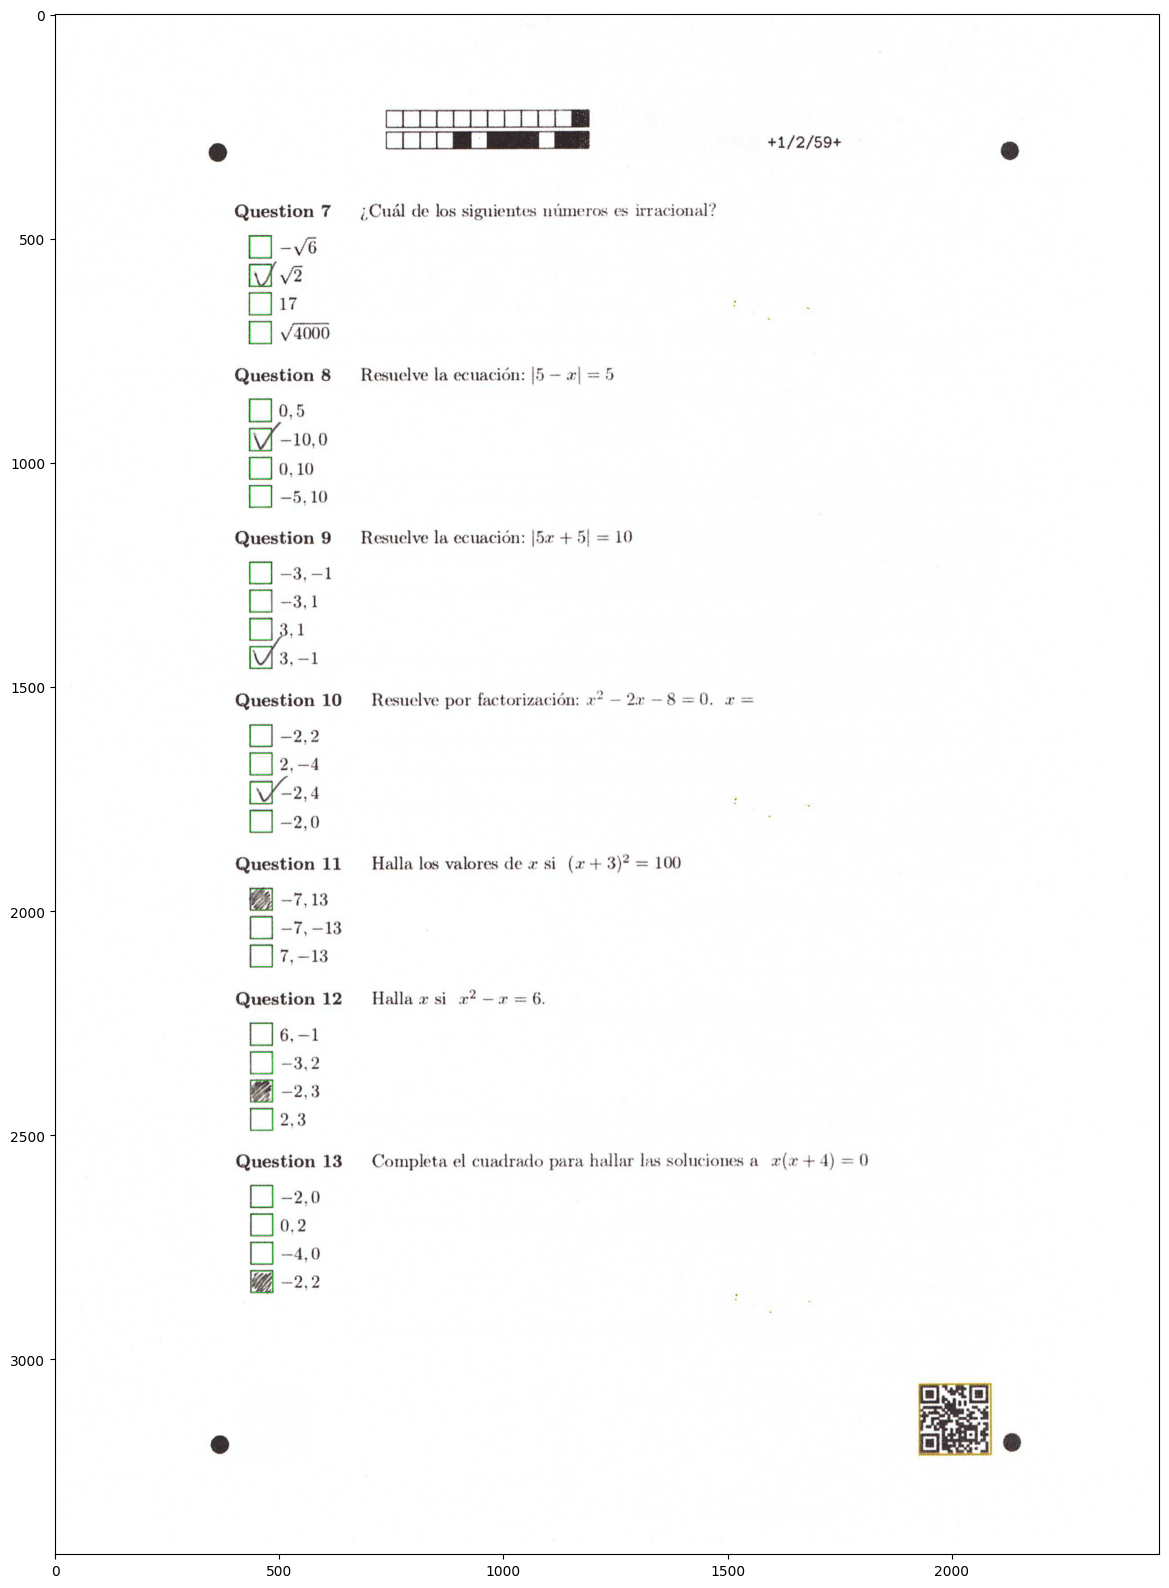

In [11]:
scan1x5_desorden = analyse('../multiple_choice_example/scanned/scanned_11111_desordenado.pdf')
scan1x5_desorden

{'exam': 'test_qr',
 'variant': '22222',
 'num_boxes': 67,
 'boxes': [{'stats': [397, 1839, 46, 47], 'page': '1', 'is_marked': True},
  {'stats': [397, 1903, 46, 46], 'page': '1', 'is_marked': False},
  {'stats': [397, 2076, 46, 47], 'page': '1', 'is_marked': True},
  {'stats': [397, 2139, 47, 47], 'page': '1', 'is_marked': False},
  {'stats': [397, 2308, 47, 47], 'page': '1', 'is_marked': True},
  {'stats': [397, 2372, 47, 46], 'page': '1', 'is_marked': False},
  {'stats': [397, 2540, 47, 49], 'page': '1', 'is_marked': True},
  {'stats': [397, 2605, 46, 47], 'page': '1', 'is_marked': False},
  {'stats': [397, 2778, 46, 47], 'page': '1', 'is_marked': True},
  {'stats': [397, 2842, 46, 46], 'page': '1', 'is_marked': False},
  {'stats': [396, 3012, 47, 46], 'page': '1', 'is_marked': True},
  {'stats': [396, 3075, 47, 48], 'page': '1', 'is_marked': False},
  {'stats': [435, 491, 47, 47], 'page': '2', 'is_marked': False},
  {'stats': [435, 555, 46, 47], 'page': '2', 'is_marked': True},
  {

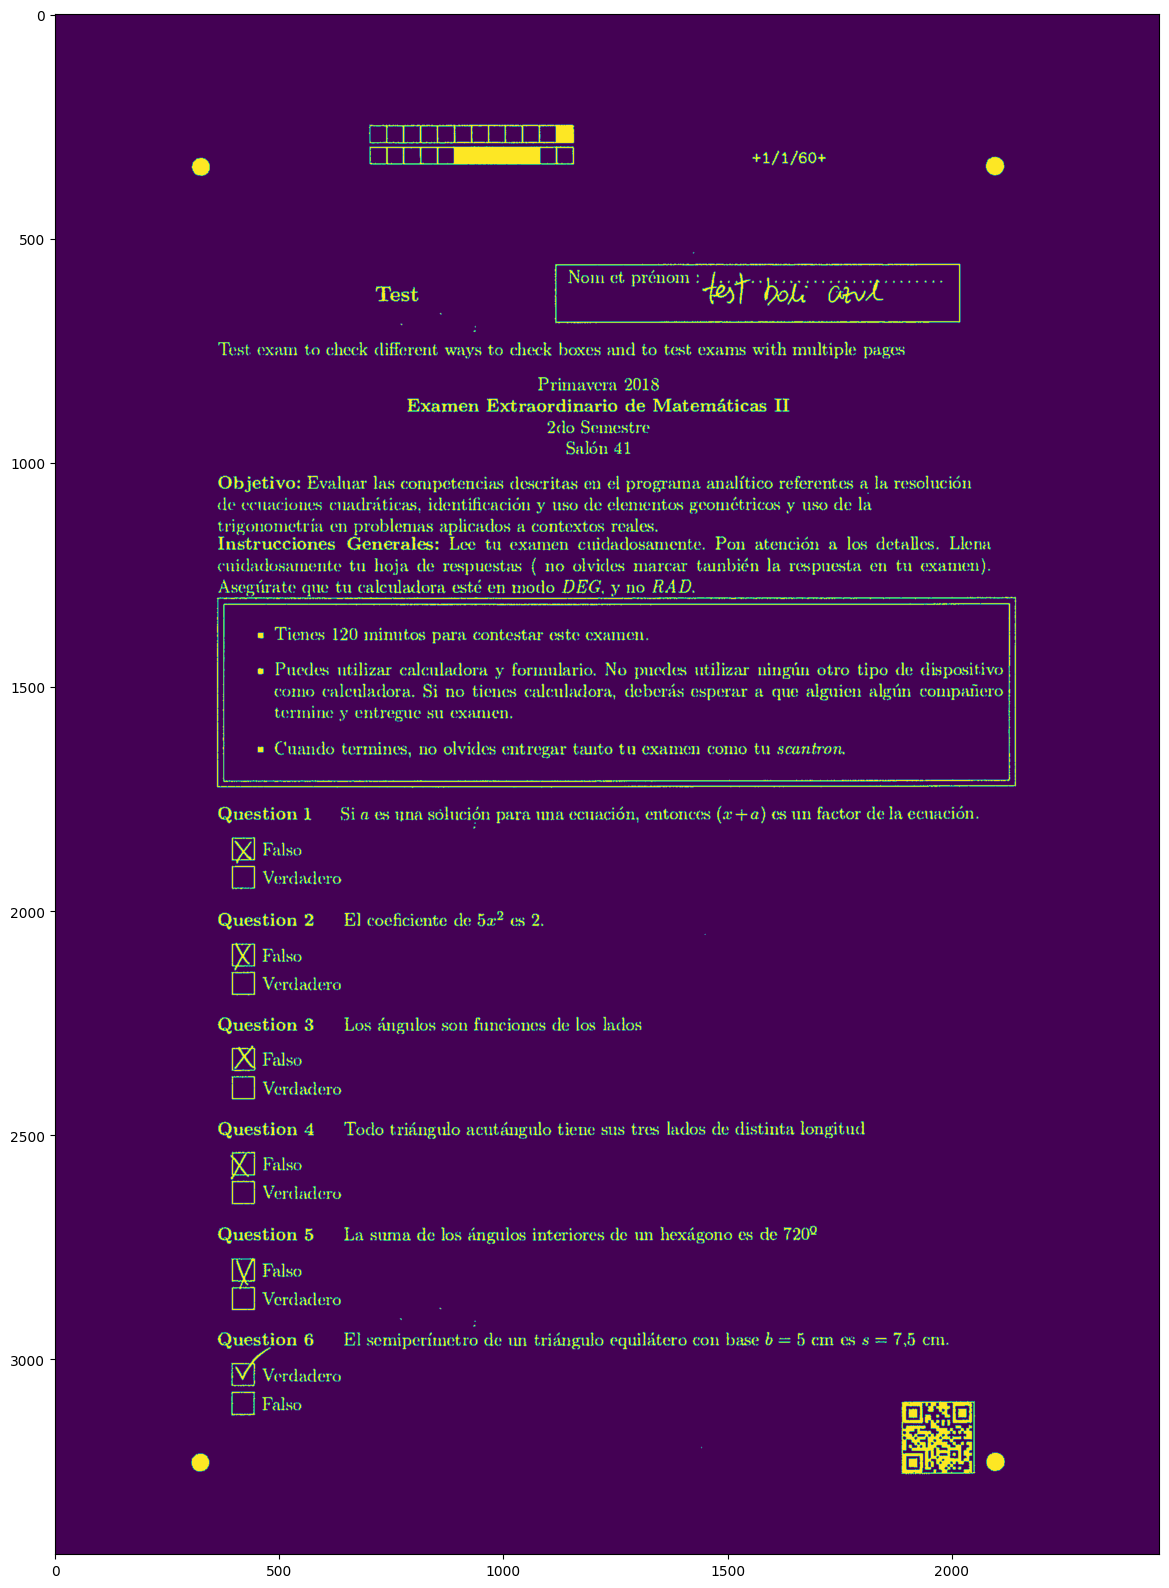

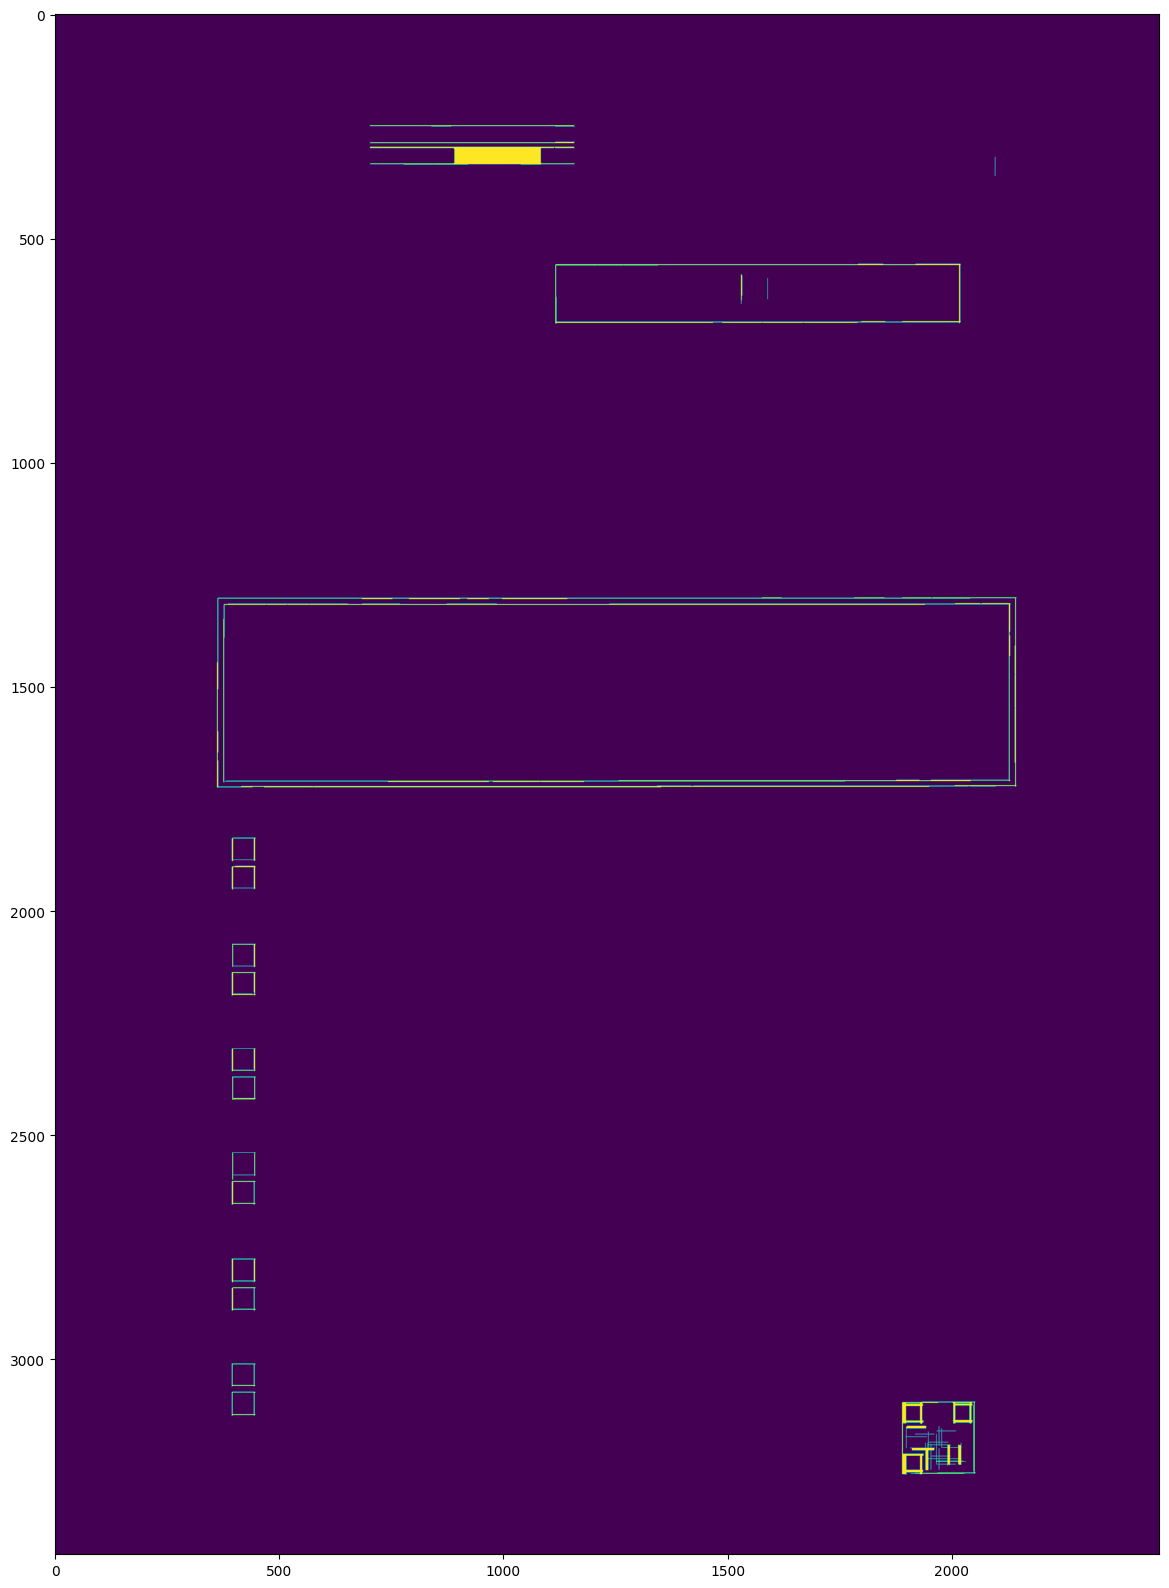

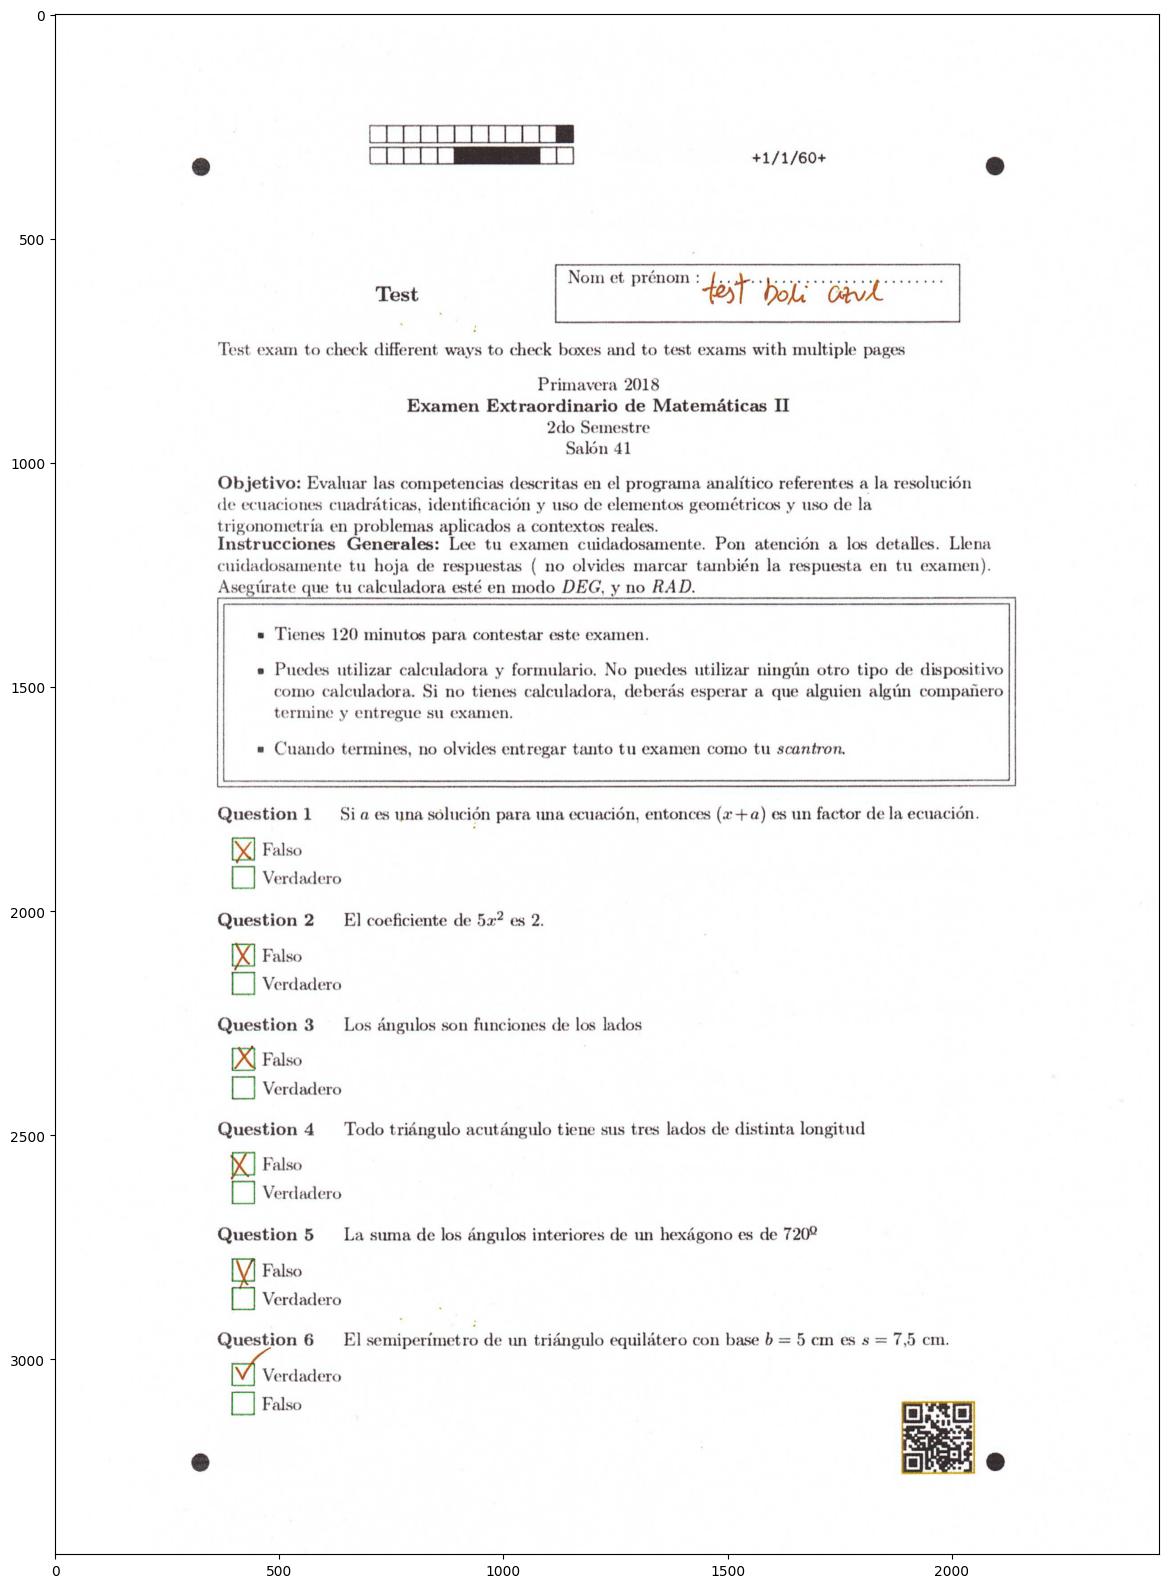

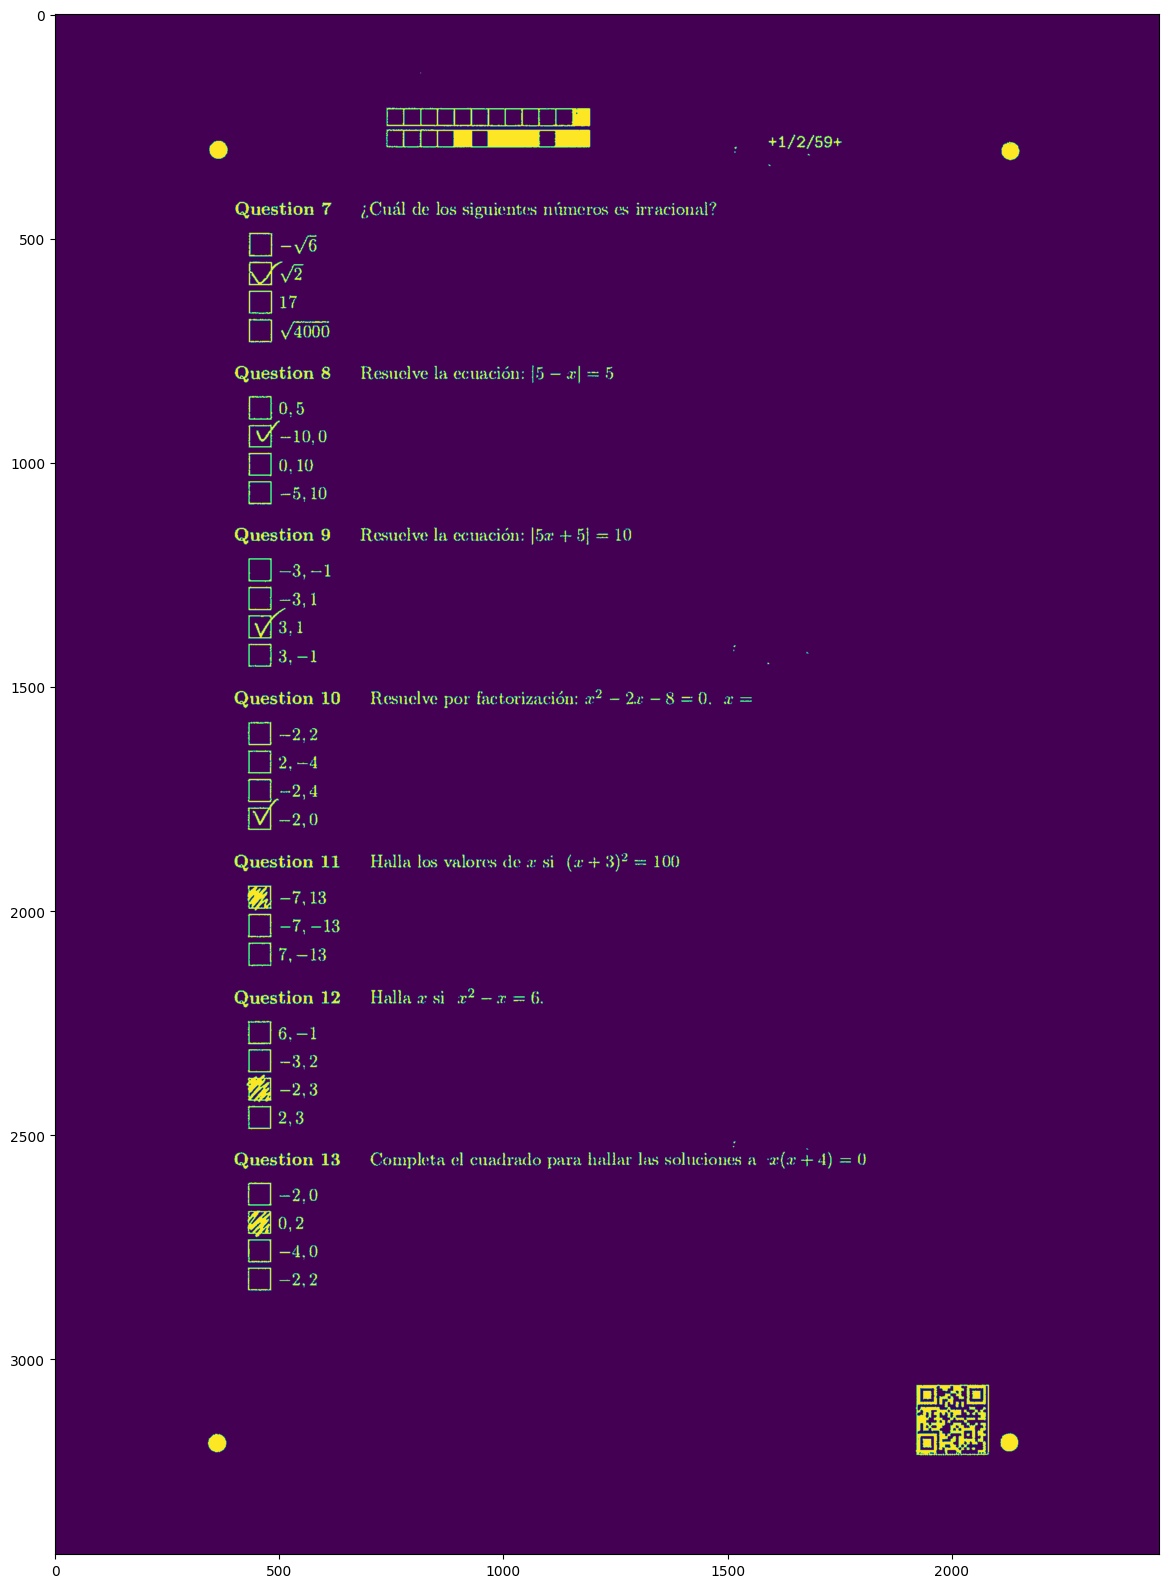

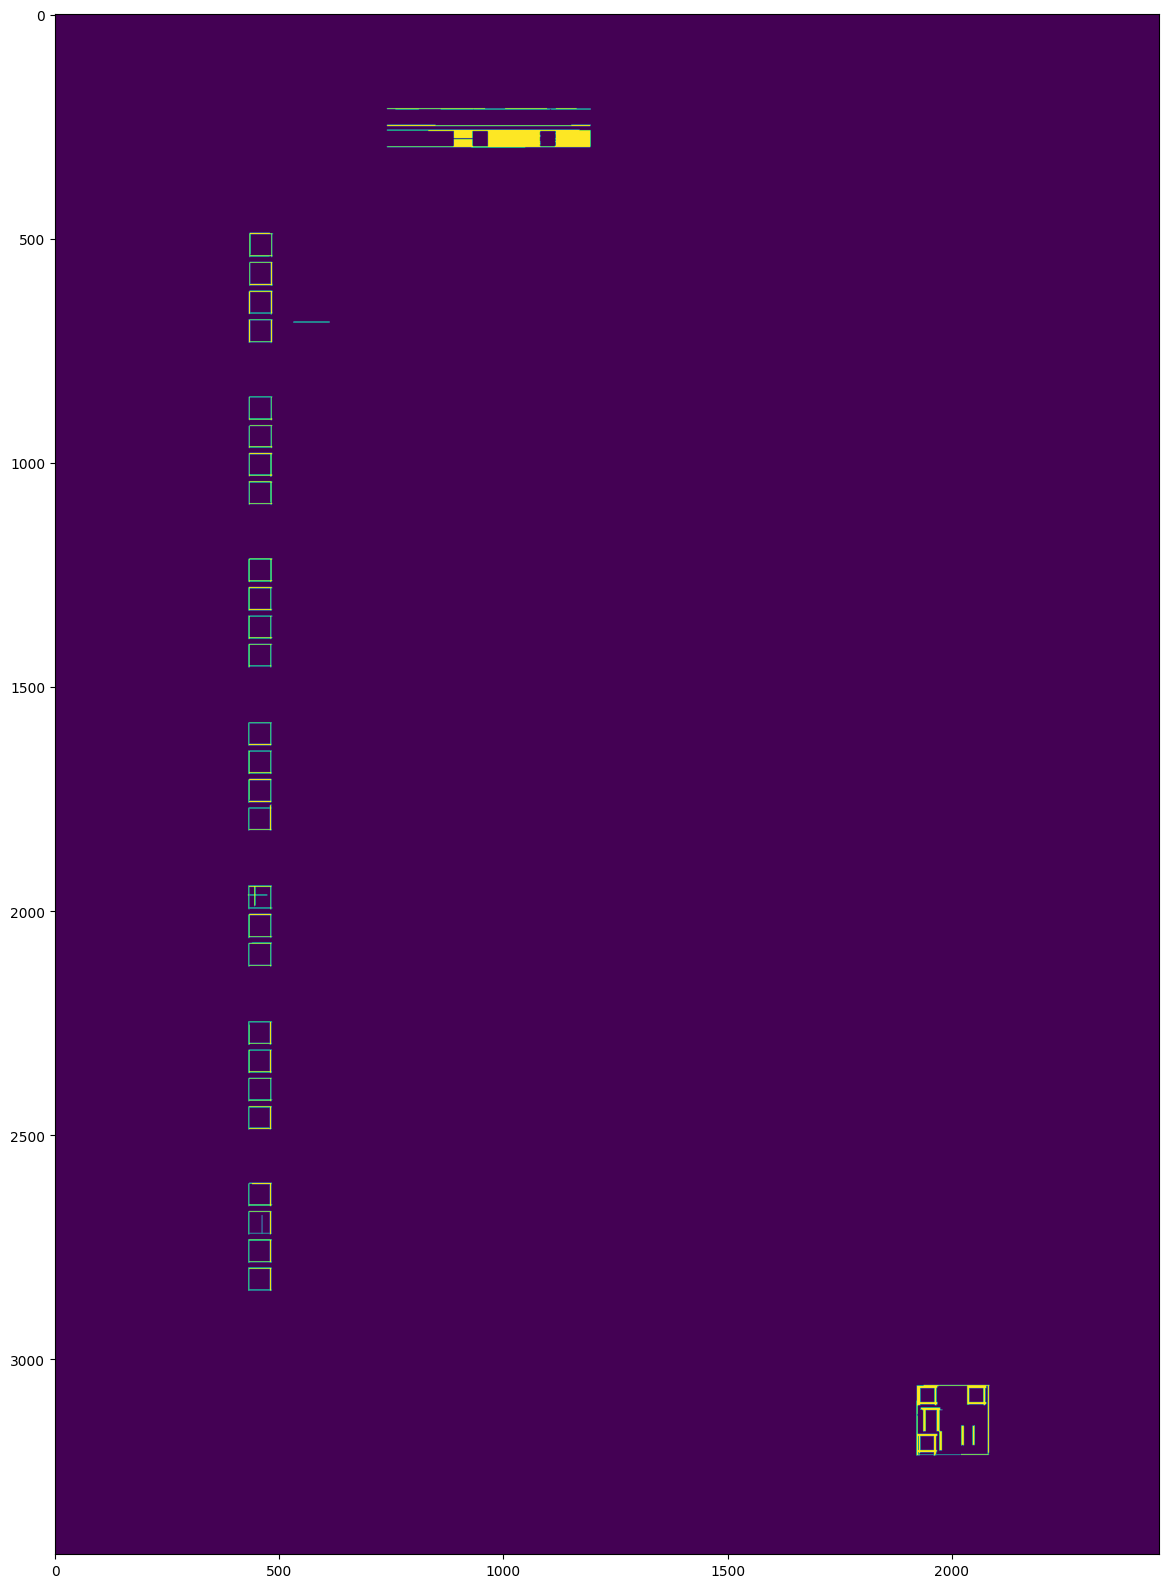

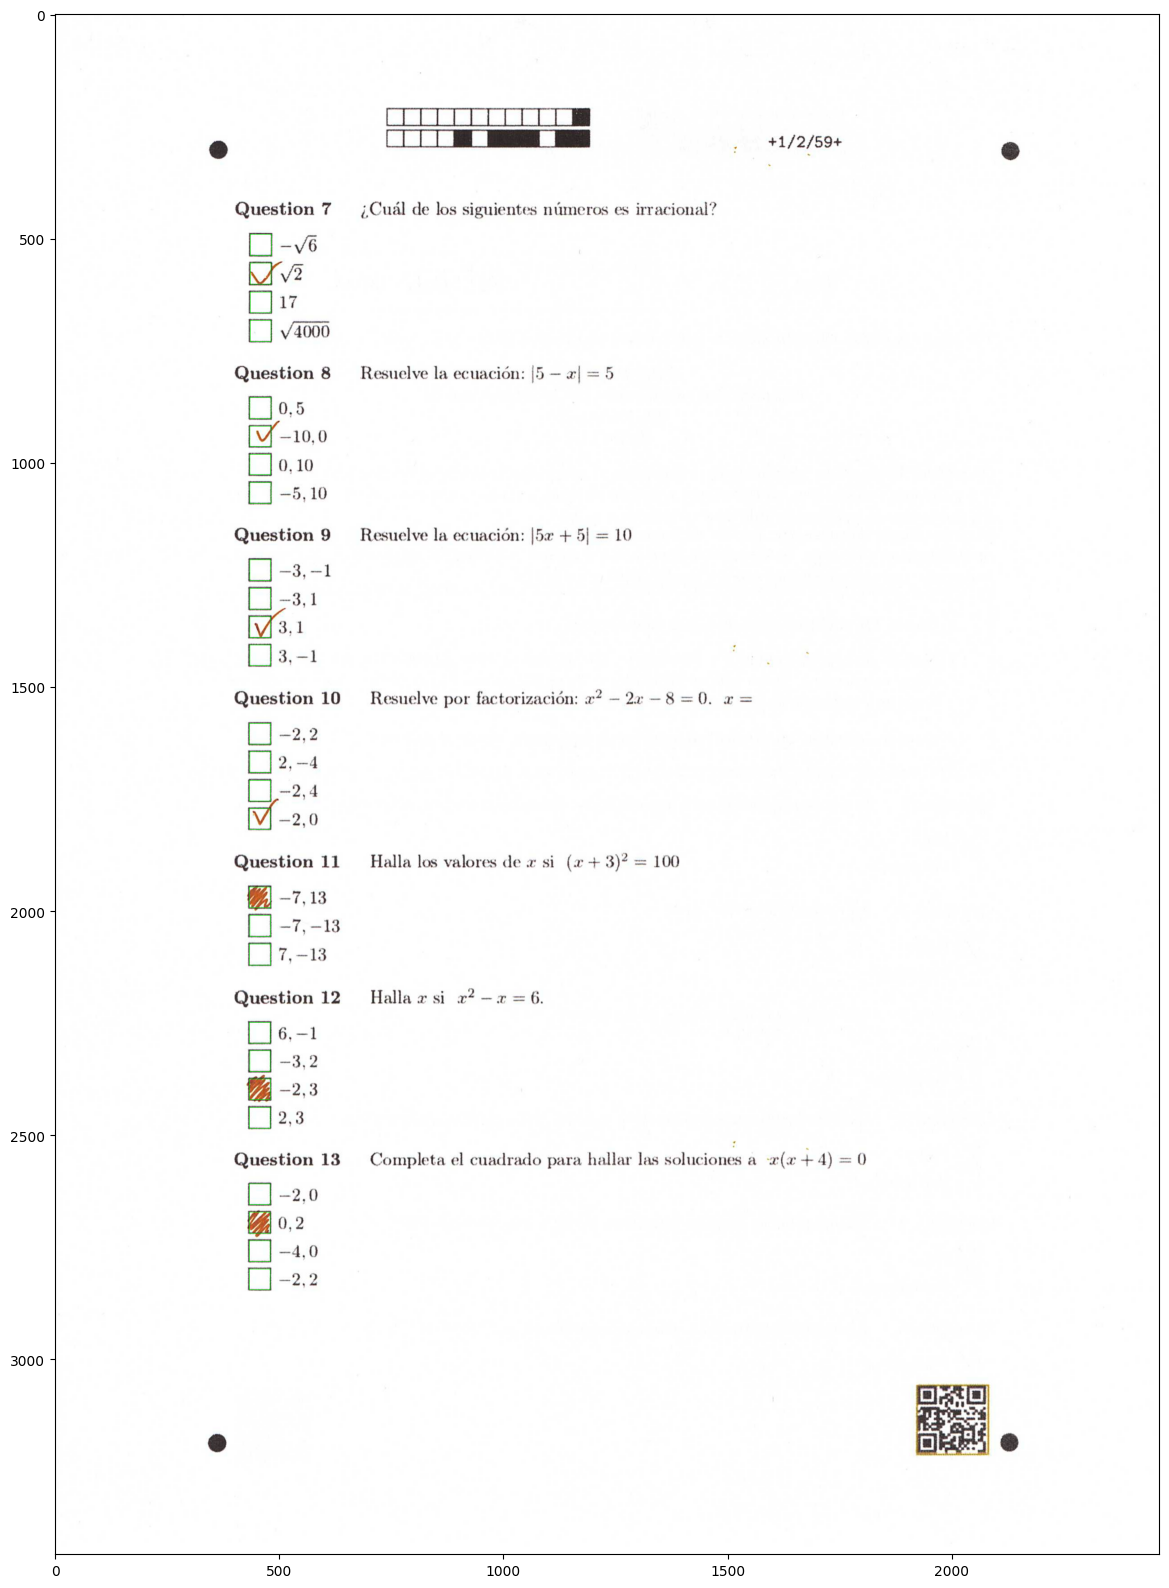

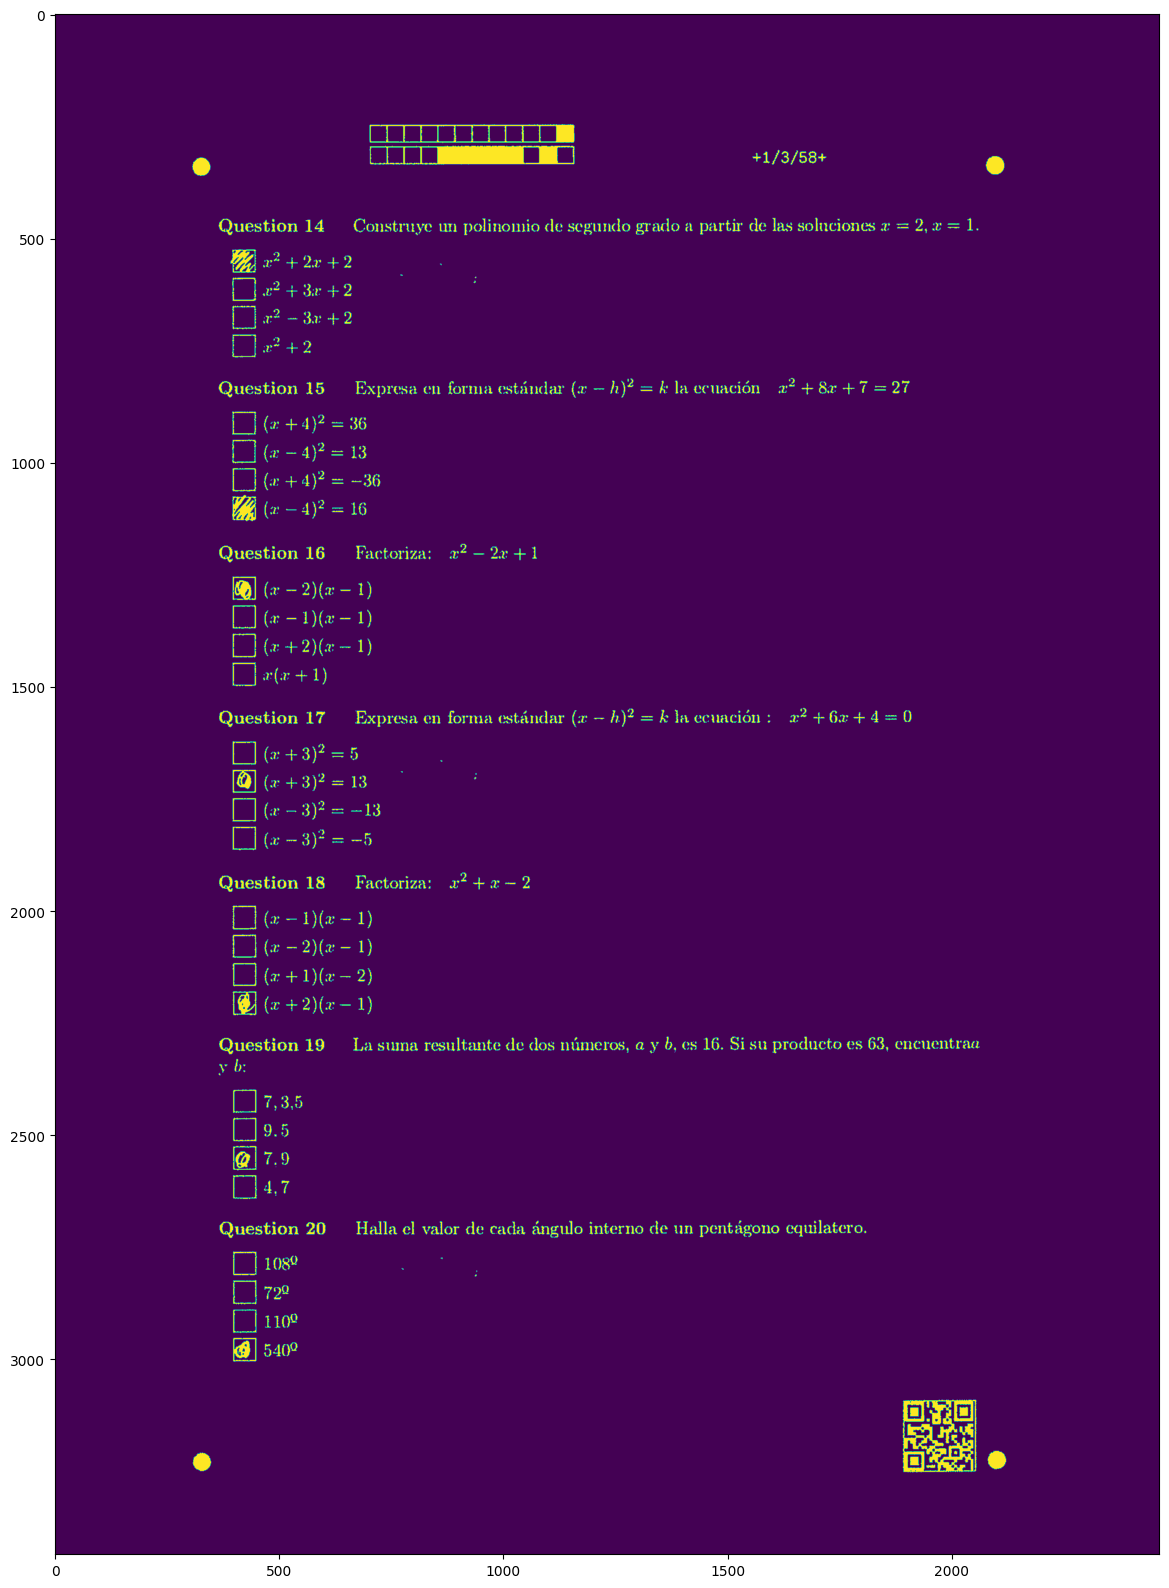

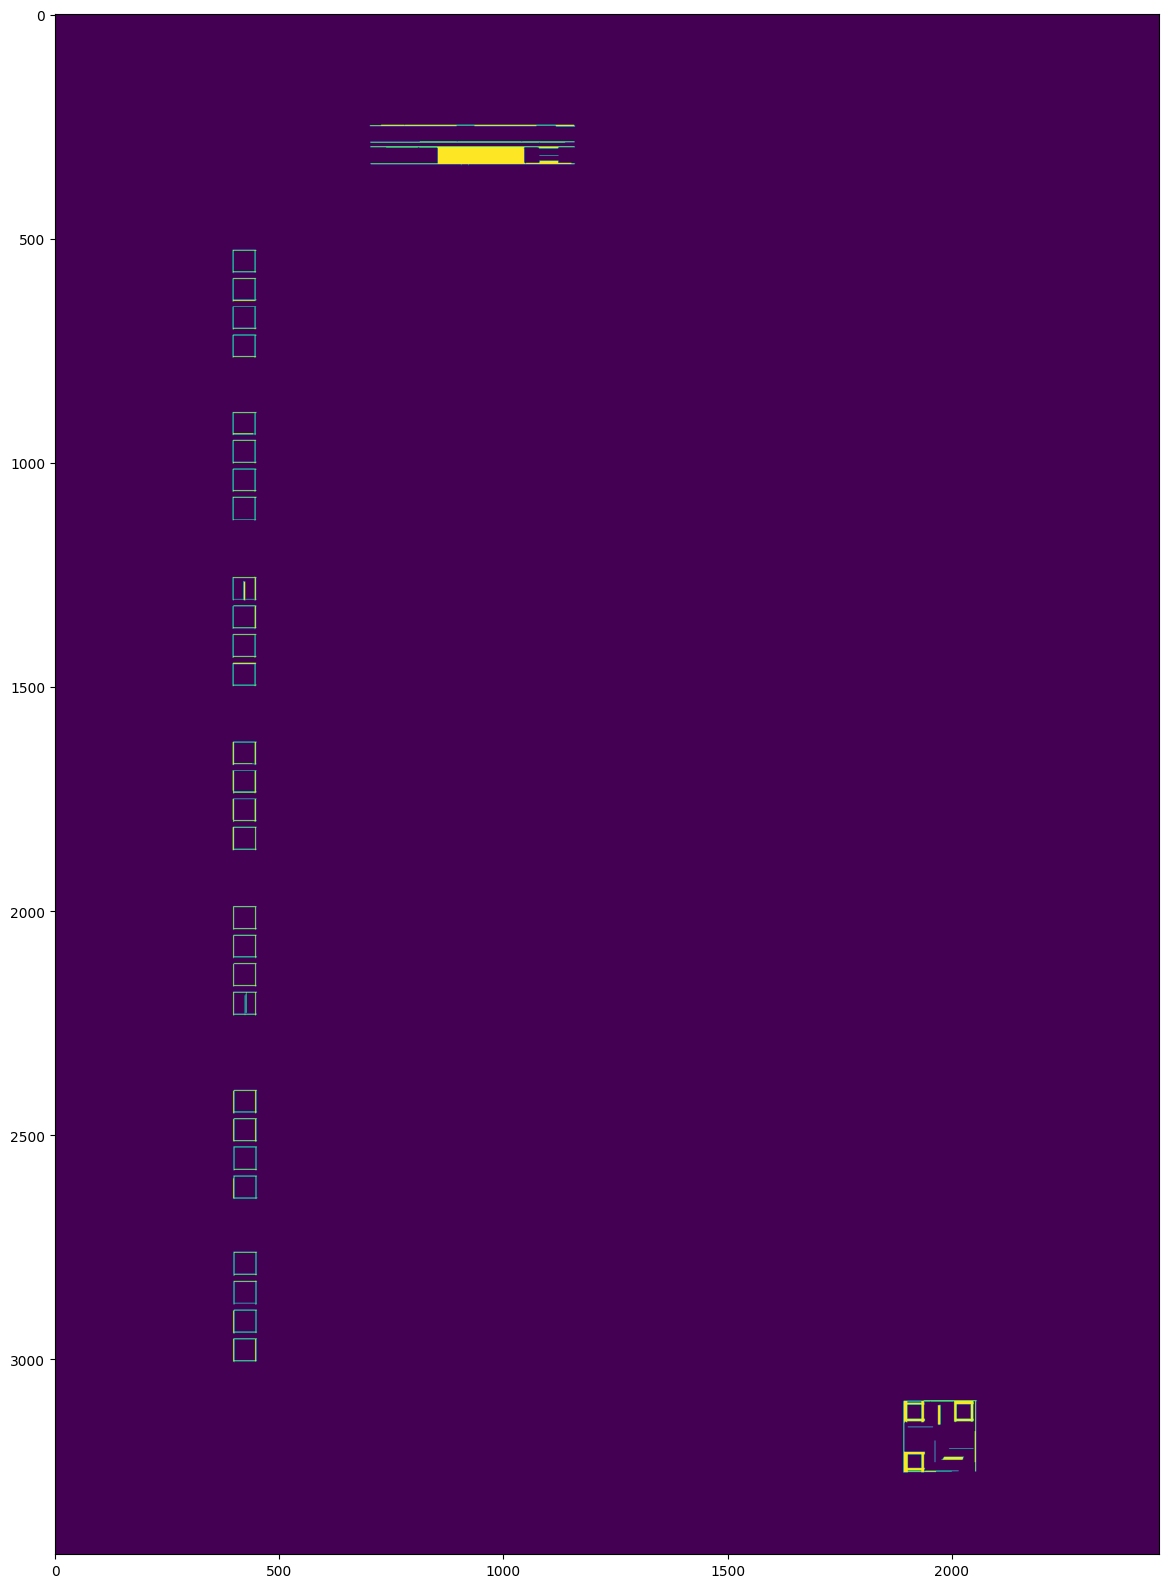

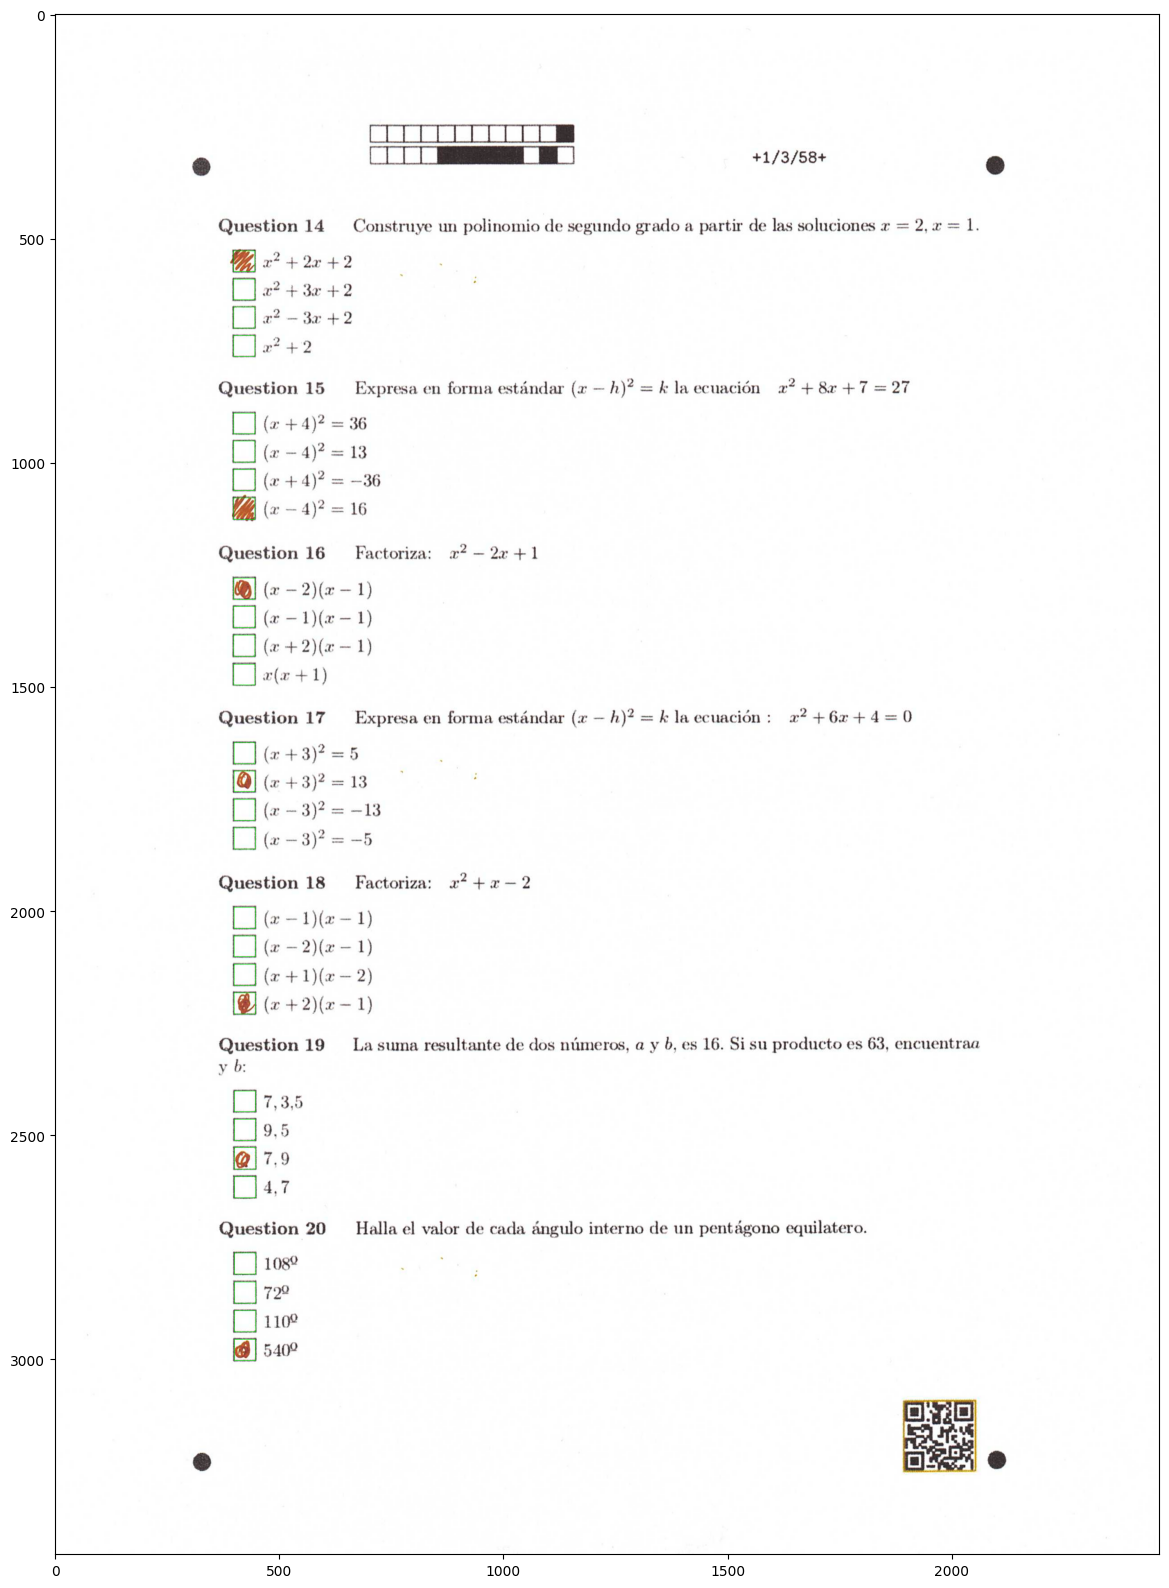

In [12]:
scan2x5 = analyse('../multiple_choice_example/scanned/scanned_22222.pdf')
scan2x5

## pruebas con examenes rellenados con editor pdf

In [13]:
filled1x5 = analyse('../multiple_choice_example/filled/filled_33333.pdf')
filled1x5

{'exam': 'test_qr',
 'variant': '33333',
 'num_boxes': 67,
 'exercises': [{'exercise': 'vf1',
   'checkboxes': [{'checkbox': '0,0',
     'cords': [93.245, 383.659, 12.716, 12.716],
     'page': 1},
    {'checkbox': '0,1',
     'cords': [93.245, 367.719, 12.716, 12.716],
     'page': 1}],
   'student_marked': ['0,0']},
  {'exercise': 'vf2',
   'checkboxes': [{'checkbox': '1,0',
     'cords': [93.245, 324.103, 12.716, 12.717],
     'page': 1},
    {'checkbox': '1,1',
     'cords': [93.245, 308.163, 12.716, 12.716],
     'page': 1}],
   'student_marked': ['1,0']},
  {'exercise': 'vf3',
   'checkboxes': [{'checkbox': '2,0',
     'cords': [93.245, 265.739, 12.716, 12.716],
     'page': 1},
    {'checkbox': '2,1',
     'cords': [93.245, 249.799, 12.716, 12.716],
     'page': 1}],
   'student_marked': ['2,0']},
  {'exercise': 'vf4',
   'checkboxes': [{'checkbox': '3,0',
     'cords': [93.245, 207.375, 12.716, 12.716],
     'page': 1},
    {'checkbox': '3,1',
     'cords': [93.245, 191.434, 12

In [14]:
filled2x5 = analyse('../multiple_choice_example/filled/filled_44444.pdf')
filled2x5

{'exam': 'test_qr',
 'variant': '44444',
 'num_boxes': 67,
 'exercises': [{'exercise': 'vf1',
   'checkboxes': [{'checkbox': '0,0',
     'cords': [93.245, 383.659, 12.716, 12.716],
     'page': 1},
    {'checkbox': '0,1',
     'cords': [93.245, 367.719, 12.716, 12.716],
     'page': 1}],
   'student_marked': ['0,0', '0,1']},
  {'exercise': 'vf2',
   'checkboxes': [{'checkbox': '1,0',
     'cords': [93.245, 324.103, 12.716, 12.717],
     'page': 1},
    {'checkbox': '1,1',
     'cords': [93.245, 308.163, 12.716, 12.716],
     'page': 1}],
   'student_marked': []},
  {'exercise': 'vf3',
   'checkboxes': [{'checkbox': '2,0',
     'cords': [93.245, 265.739, 12.716, 12.716],
     'page': 1},
    {'checkbox': '2,1',
     'cords': [93.245, 249.799, 12.716, 12.716],
     'page': 1}],
   'student_marked': ['2,0']},
  {'exercise': 'vf4',
   'checkboxes': [{'checkbox': '3,0',
     'cords': [93.245, 207.375, 12.716, 12.716],
     'page': 1},
    {'checkbox': '3,1',
     'cords': [93.245, 191.434, 

In [15]:
def format_scan(sol_data, scan_data):
    if not sol_data['num_boxes'] == scan_data['num_boxes']:
        error = 'Number of boxes incorrect'
        return {}
    data = {'exam': scan_data['exam'],
            'variant': scan_data['variant'],
            'num_boxes': scan_data['num_boxes'],
            'exercises': []
            }
    comparison = []
    count_ex = 0
    count_box = -1
    for scan_box in scan_data['boxes']:
        count_box = count_box + 1
        if sol_data['exercises'][count_ex]['checkboxes'].__len__() == count_box:
            count_box = 0
            count_ex = count_ex + 1
        if count_box == 0:
            data['exercises'].append({'exercise': sol_data['exercises'][count_ex]['exercise'],
                                      'checkboxes': [],
                                      'student_marked': []
                                      })
        sol_box = sol_data['exercises'][count_ex]['checkboxes'][count_box]
        data['exercises'][count_ex]['checkboxes'].append({'checkbox': sol_box['checkbox'],
                                                         'stats': scan_box['stats'],
                                                         'page': scan_box['page'],
                                                         'is_marked': scan_box['is_marked'],
                                                         })
        if scan_box['is_marked']:
            data['exercises'][count_ex]['student_marked'].append(sol_box['checkbox'])
        st_x = sol_box['cords'][0]
        st_y = sol_box['cords'][1]
        sc_x = scan_box['stats'][0]
        sc_y= scan_box['stats'][1]
        factor_x = sc_x / st_x
        factor_y = sc_y / st_y
        comparison.append({'cords_st': (st_x, st_y),
                           'cords_scan': (sc_x, sc_y),
                           'factors': (factor_x, factor_y)
                           })
    return comparison, data

In [16]:
sol_file1 = '../multiple_choice_example/json/solution_11111.json'
sol_file2 = '../multiple_choice_example/json/solution_22222.json'
with open(sol_file1) as json_file:
    data_sol1 = json.load(json_file)
with open(sol_file2) as json_file:
    data_sol2 = json.load(json_file)

In [17]:
data_sol1['exercises'][5]

{'exercise': 'vf6',
 'checkboxes': [{'checkbox': '5,0',
   'cords': [105.961, 107.707, 12.716, 12.717],
   'page': 1,
   'is_marked': True},
  {'checkbox': '5,1',
   'cords': [105.961, 91.767, 12.716, 12.716],
   'page': 1,
   'is_marked': False}],
 'sol_marked': ['5,0']}

In [18]:
comp1, data_scan1 = format_scan(data_sol1, scan1x5)
comp1

[{'cords_st': (105.961, 401.272),
  'cords_scan': (400, 1840),
  'factors': (3.7749738111191853, 4.585418369584721)},
 {'cords_st': (105.961, 385.332),
  'cords_scan': (400, 1905),
  'factors': (3.7749738111191853, 4.943788732832986)},
 {'cords_st': (105.961, 341.717),
  'cords_scan': (400, 2079),
  'factors': (3.7749738111191853, 6.08398177439226)},
 {'cords_st': (105.961, 325.776),
  'cords_scan': (400, 2142),
  'factors': (3.7749738111191853, 6.575069986739354)},
 {'cords_st': (105.961, 283.352),
  'cords_scan': (400, 2311),
  'factors': (3.7749738111191853, 8.155933256161948)},
 {'cords_st': (105.961, 267.412),
  'cords_scan': (400, 2376),
  'factors': (3.7749738111191853, 8.885165961138618)},
 {'cords_st': (105.961, 224.988),
  'cords_scan': (400, 2542),
  'factors': (3.7749738111191853, 11.298380358063541)},
 {'cords_st': (105.961, 209.048),
  'cords_scan': (400, 2607),
  'factors': (3.7749738111191853, 12.470820098733306)},
 {'cords_st': (105.961, 166.072),
  'cords_scan': (400,

In [19]:
data_scan1

{'exam': 'test_qr',
 'variant': '11111',
 'num_boxes': 67,
 'exercises': [{'exercise': 'vf1',
   'checkboxes': [{'checkbox': '0,0',
     'stats': [400, 1840, 46, 48],
     'page': '1',
     'is_marked': True},
    {'checkbox': '0,1',
     'stats': [400, 1905, 46, 47],
     'page': '1',
     'is_marked': False}],
   'student_marked': ['0,0']},
  {'exercise': 'vf2',
   'checkboxes': [{'checkbox': '1,0',
     'stats': [400, 2079, 46, 47],
     'page': '1',
     'is_marked': False},
    {'checkbox': '1,1',
     'stats': [400, 2142, 46, 47],
     'page': '1',
     'is_marked': True}],
   'student_marked': ['1,1']},
  {'exercise': 'vf3',
   'checkboxes': [{'checkbox': '2,0',
     'stats': [400, 2311, 47, 48],
     'page': '1',
     'is_marked': True},
    {'checkbox': '2,1',
     'stats': [400, 2376, 47, 46],
     'page': '1',
     'is_marked': False}],
   'student_marked': ['2,0']},
  {'exercise': 'vf4',
   'checkboxes': [{'checkbox': '3,0',
     'stats': [400, 2542, 47, 49],
     'page': '